In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [4]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))

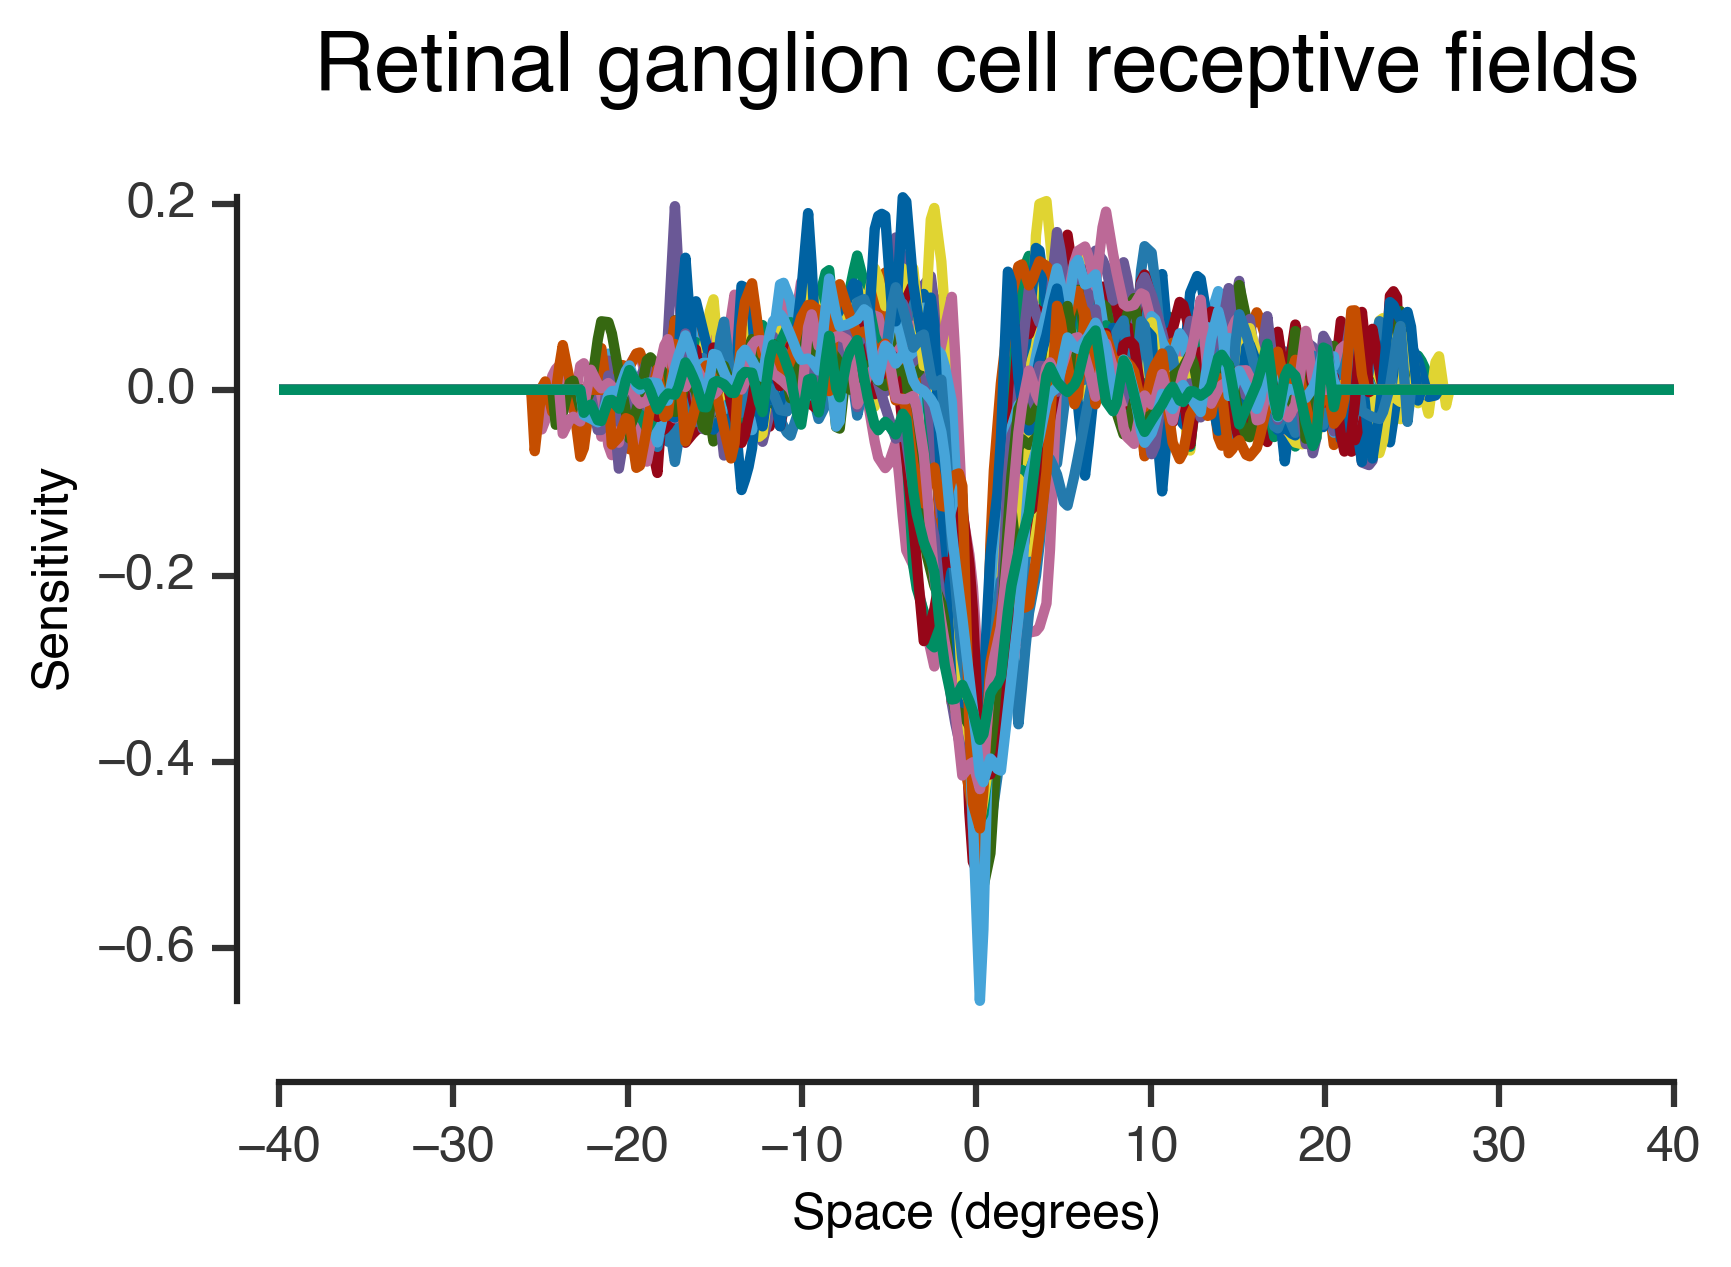

In [5]:
for c in receptive_fields['ganglion']:
    plt.plot(space, c)
plt.xlabel('Space (degrees)')
plt.ylabel('Sensitivity')
plt.title('Retinal ganglion cell receptive fields')
adjust_spines(plt.gca())

Average retinal ganglion cell receptive field

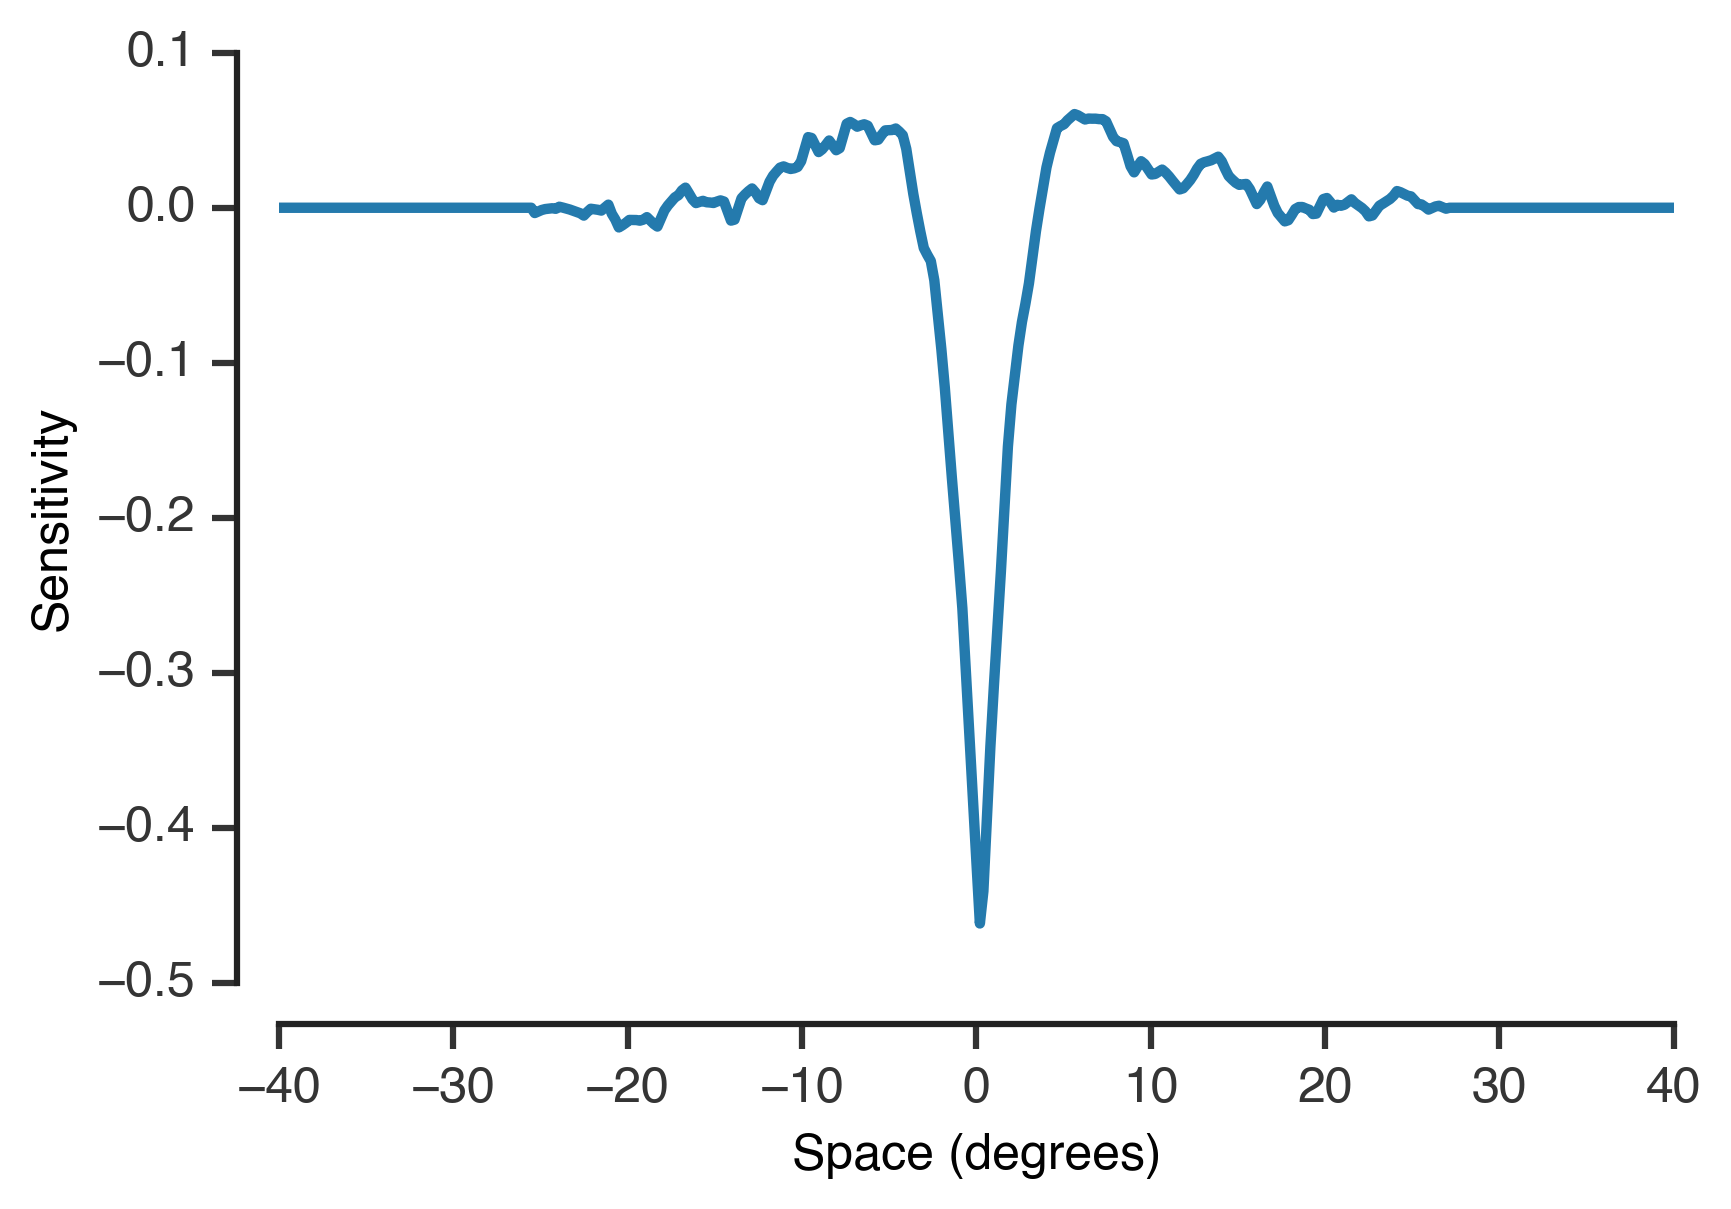

In [6]:
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)
plt.plot(space, average_ganglion_rf)
plt.ylabel('Sensitivity')
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

### Compute projective fields

In [7]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

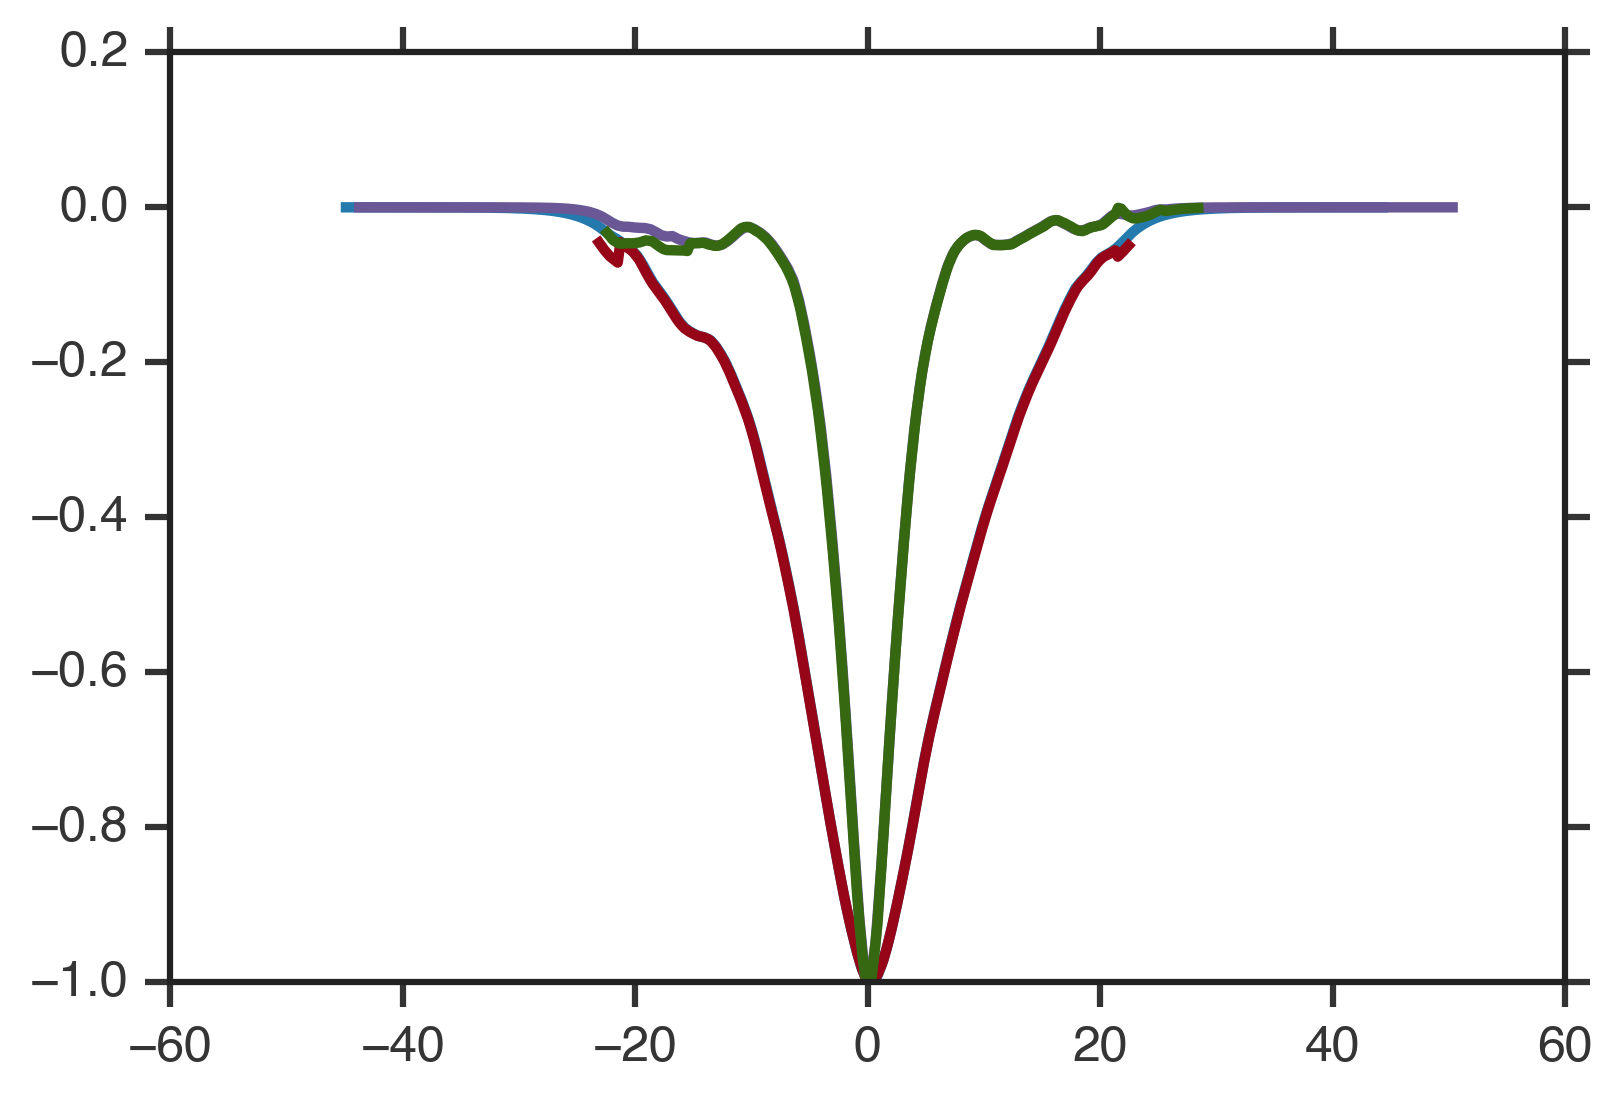

In [8]:
plt.plot(space_h_full, horz_pf_full/np.max(abs(horz_pf_full)))
plt.plot(space_h_same, horz_pf_same/np.max(abs(horz_pf_same)))
plt.plot(space_a_full, ama_pf_full/np.max(abs(ama_pf_full)))
plt.plot(space_a_same, ama_pf_same/np.max(abs(ama_pf_same)))

In [9]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

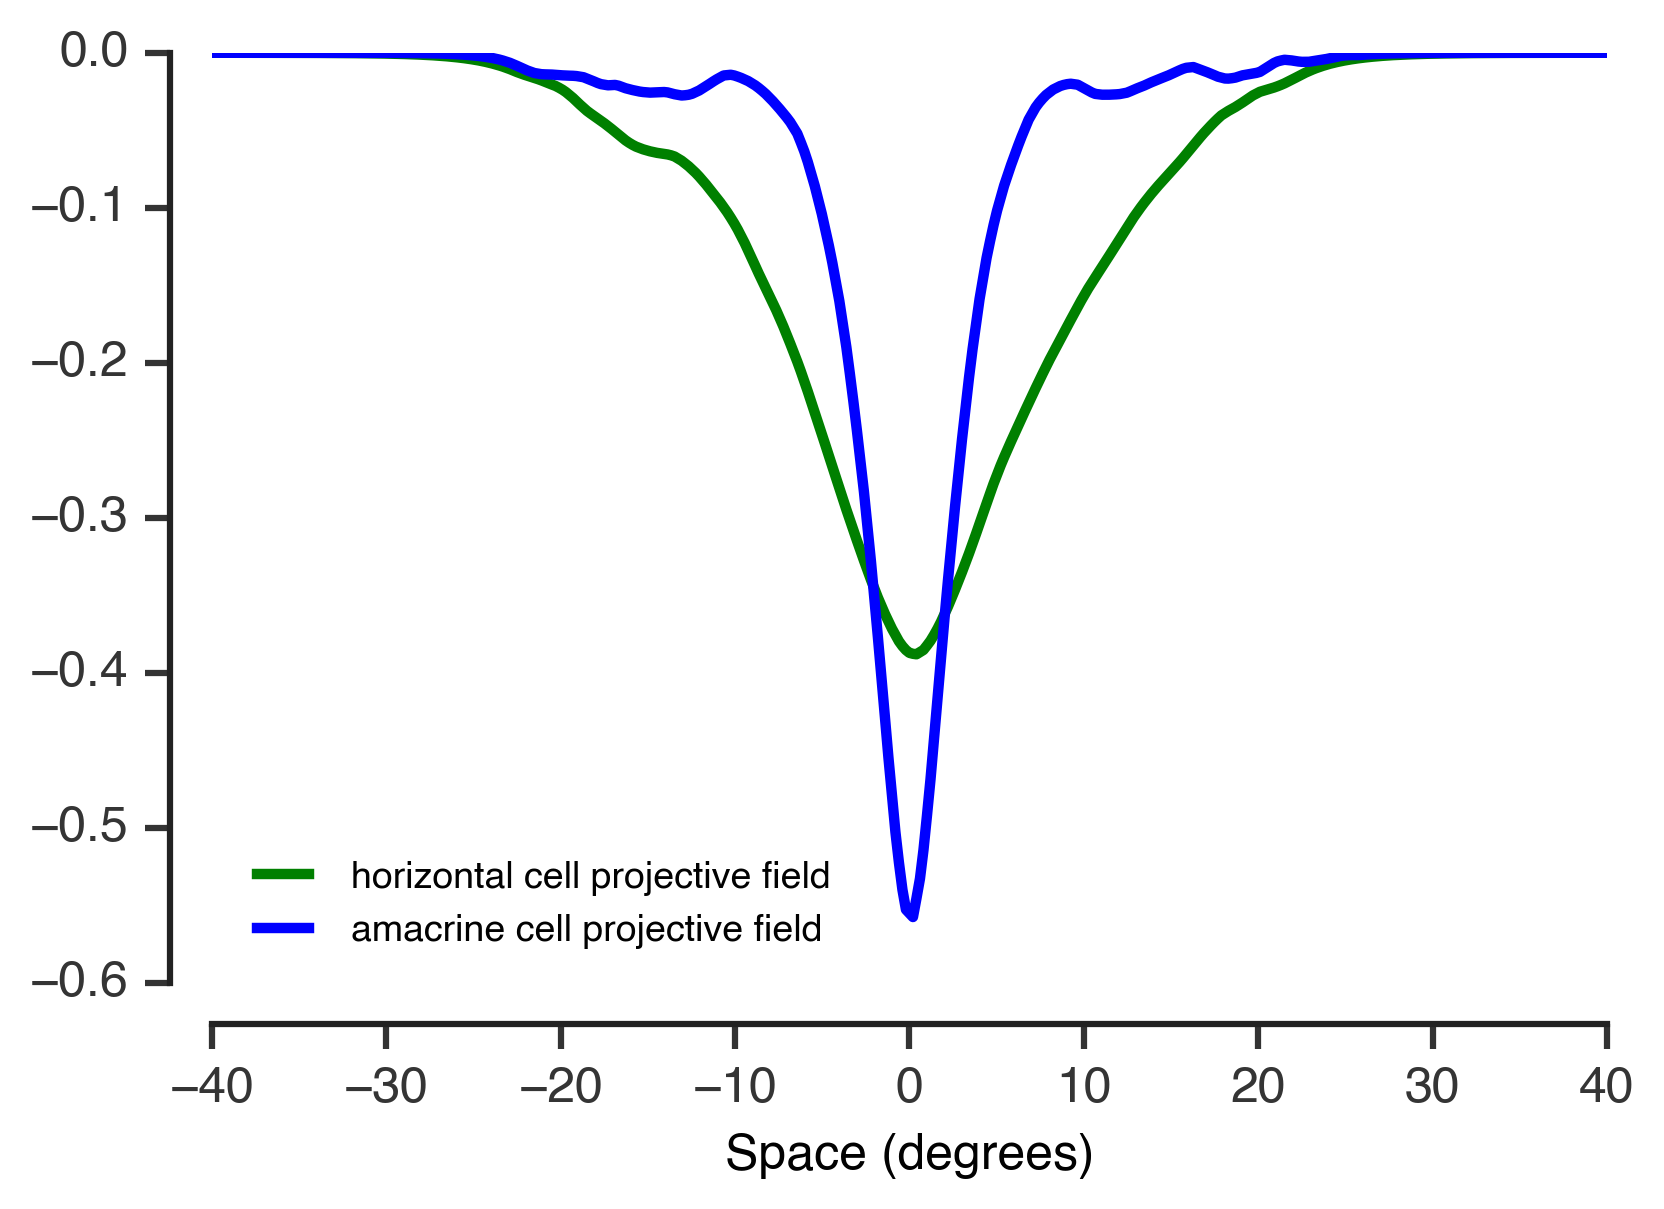

In [10]:
plt.plot(space, horz_pf, 'g', label='horizontal cell projective field')
plt.plot(space, ama_pf, 'b', label='amacrine cell projective field')
plt.legend(frameon=False, fontsize=9, loc='lower left')
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

### Signal

In [11]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [12]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


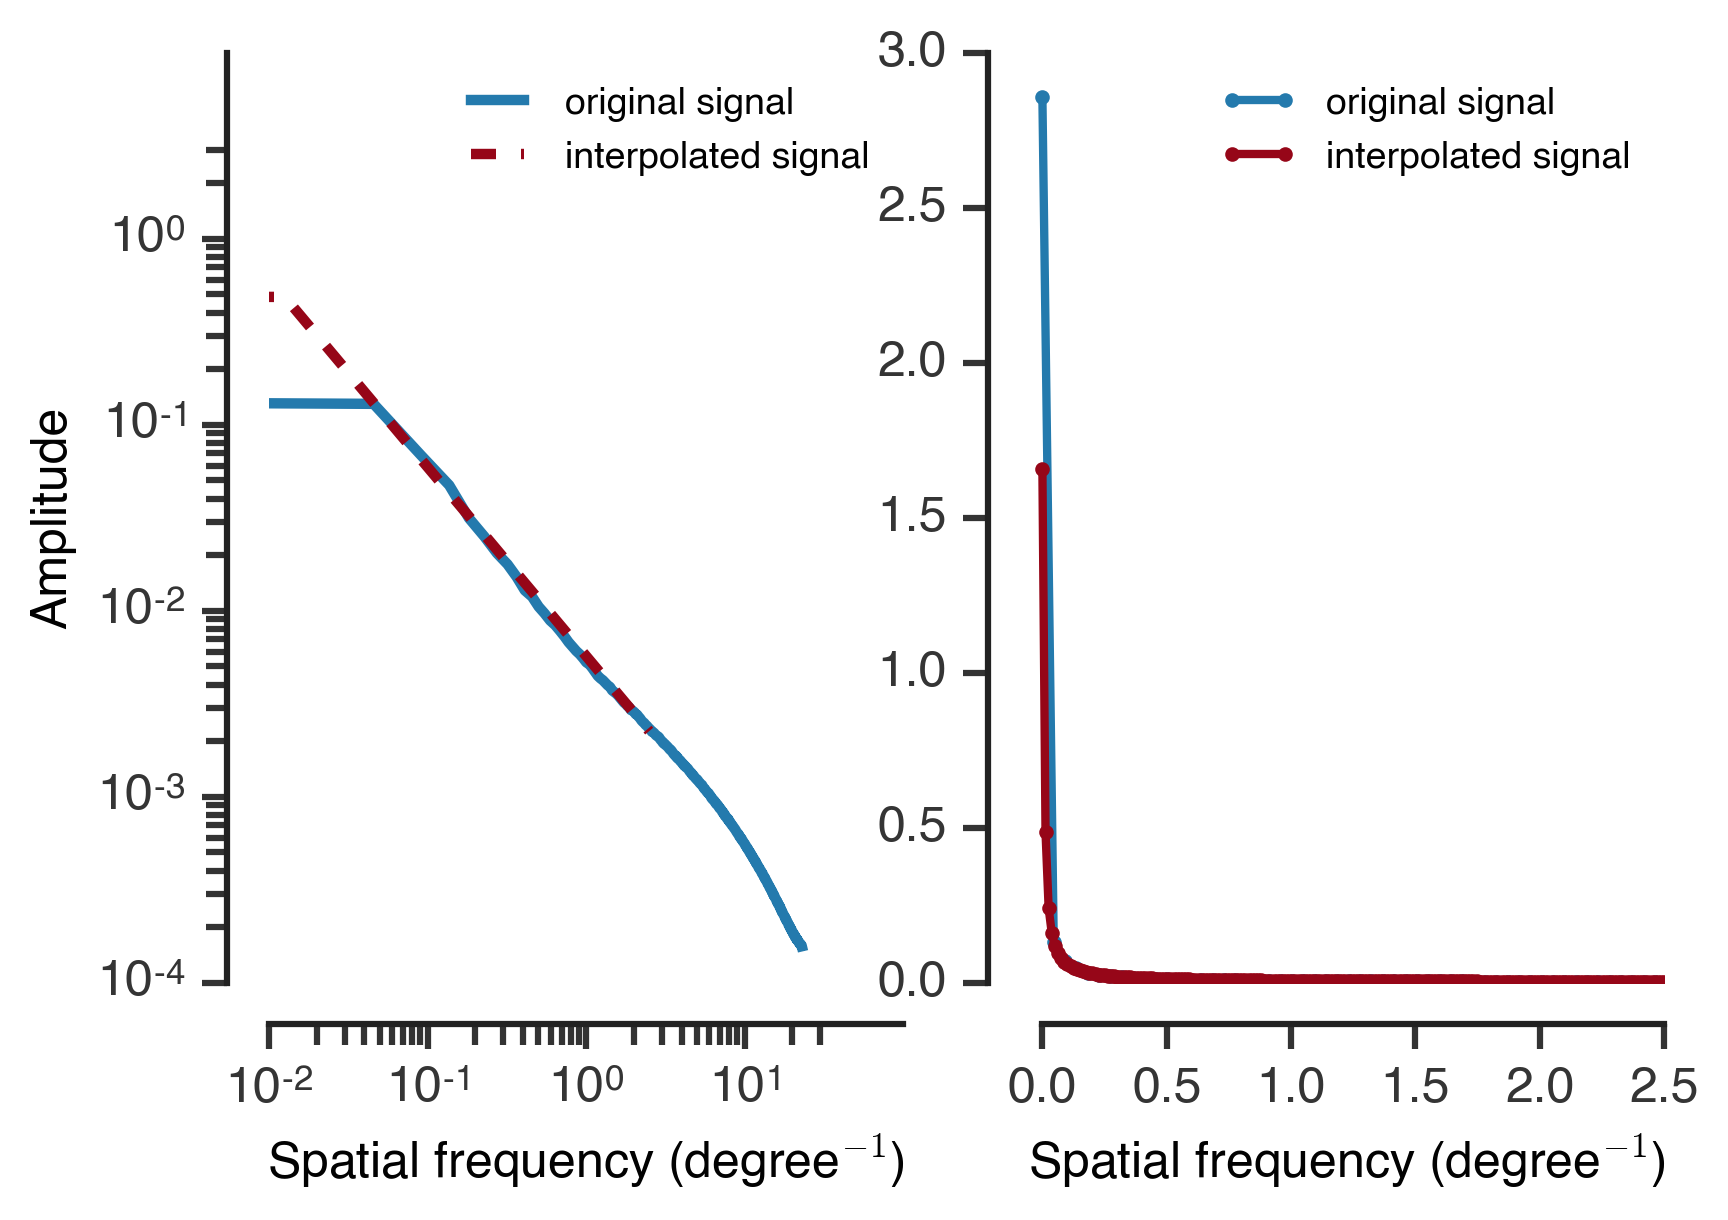

In [13]:
plt.subplot(121)
plt.plot(signal_freqs, signal_amps, label='original signal')
plt.plot(freqs, signal, '--', label='interpolated signal')
plt.legend(frameon=False, fontsize=9)
plt.xscale('log')
plt.yscale('log')
adjust_spines(plt.gca())
plt.xlabel('Spatial frequency (degree$^{-1}$)')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.plot(signal_freqs, signal_amps, '.-', markersize=6, linewidth=2, label='original signal')
plt.plot(freqs, signal, '.-', markersize=6, linewidth=2, label='interpolated signal')
adjust_spines(plt.gca())
plt.xlim(-.05, 2.5)
# plt.ylim(-.05, 1.8)
plt.xlabel('Spatial frequency (degree$^{-1}$)')
# plt.ylabel('Amplitude')
plt.legend(frameon=False, fontsize=9)

### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [14]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

1.92576130327


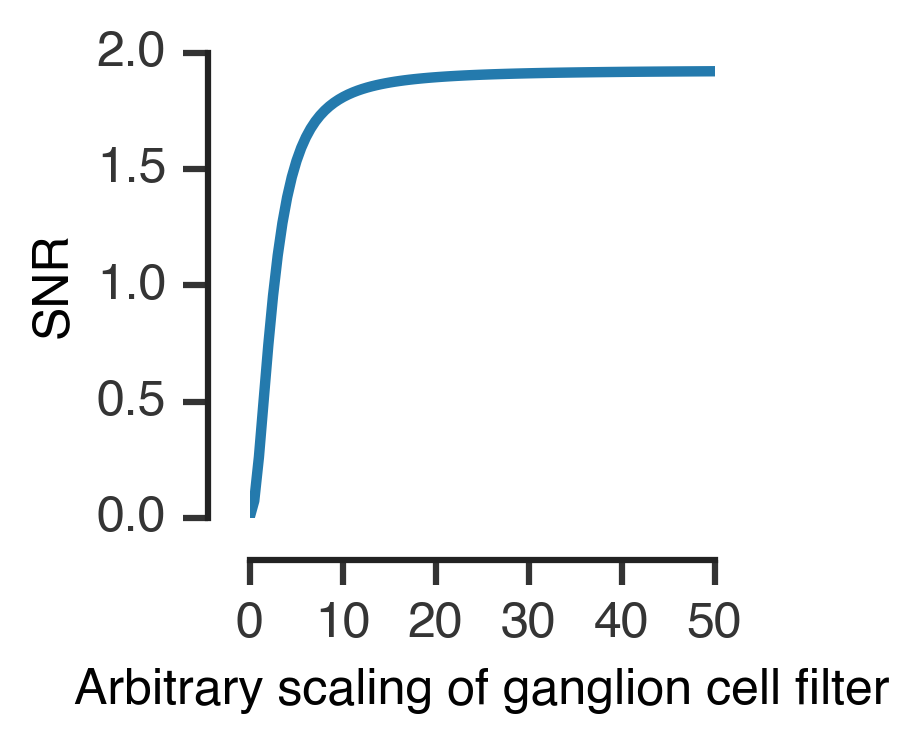

In [15]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [16]:
print(get_snr(0.1, 0.35, signal, 2*average_ganglion_fft, mode='variance'))

0.727739726792


### Ideal filter

In [17]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 1.2419907606e-08.


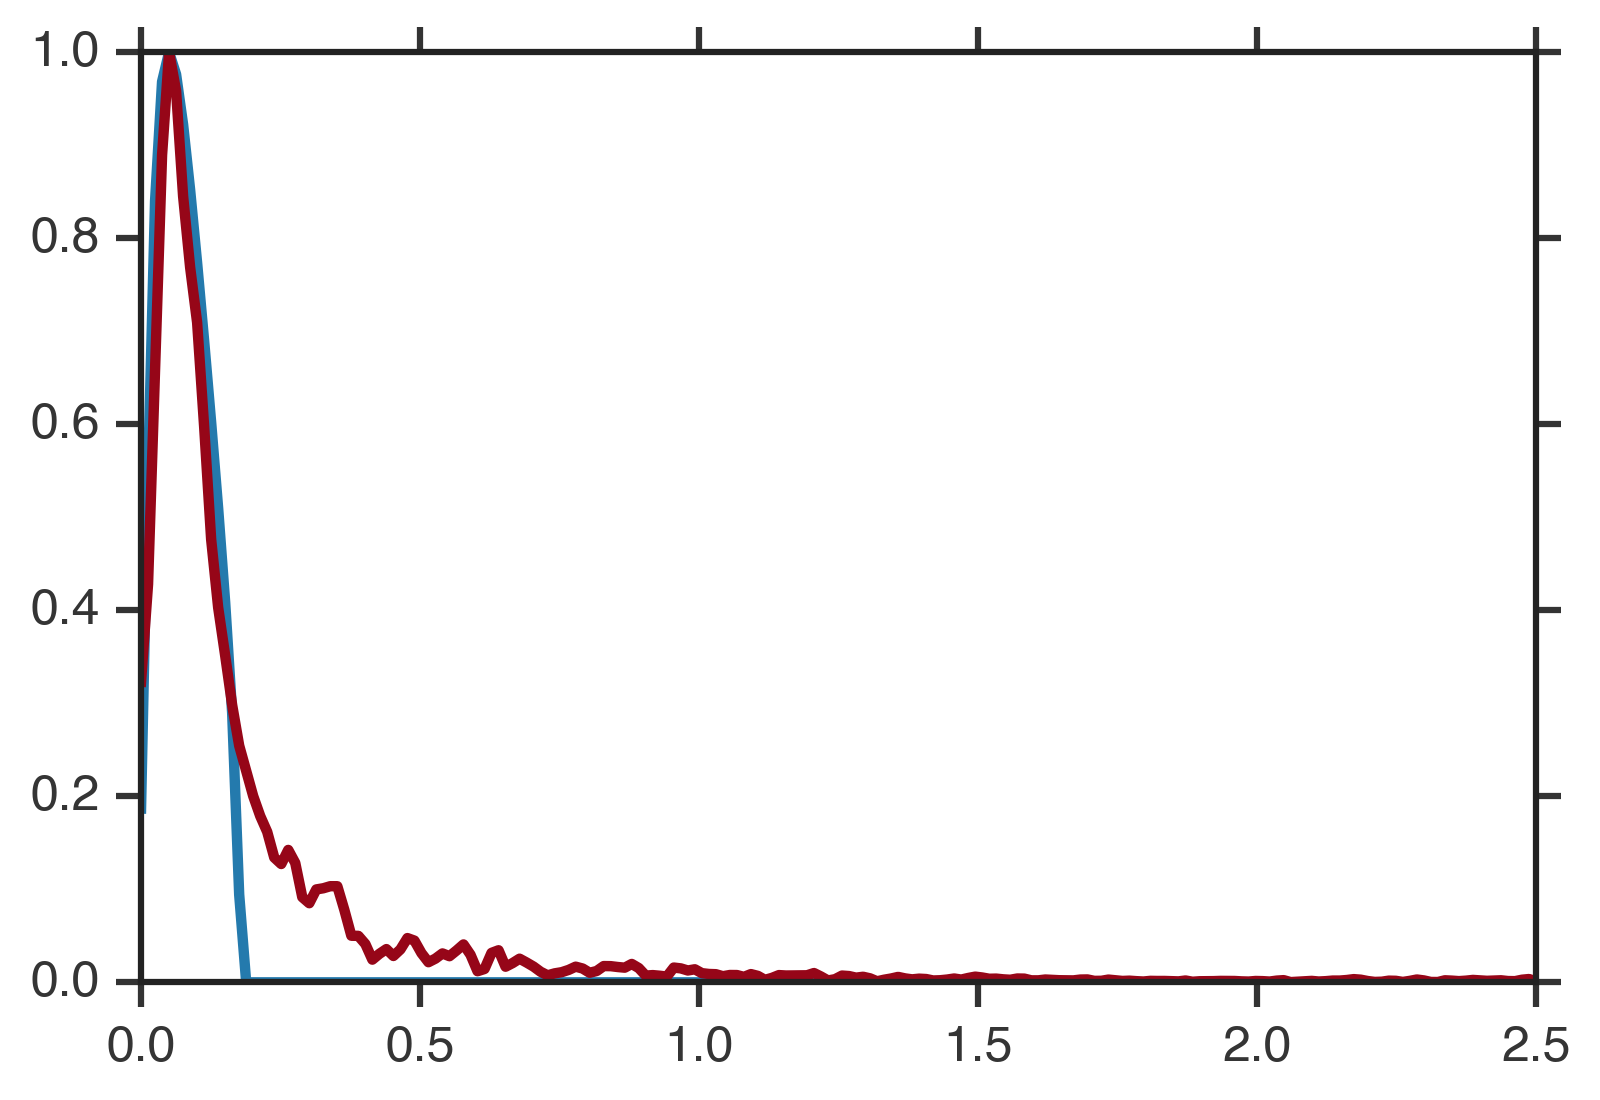

In [18]:
plt.plot(freqs, ideal_filter/np.max(ideal_filter))
plt.plot(freqs, average_ganglion_fft/np.max(average_ganglion_fft))

### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [19]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

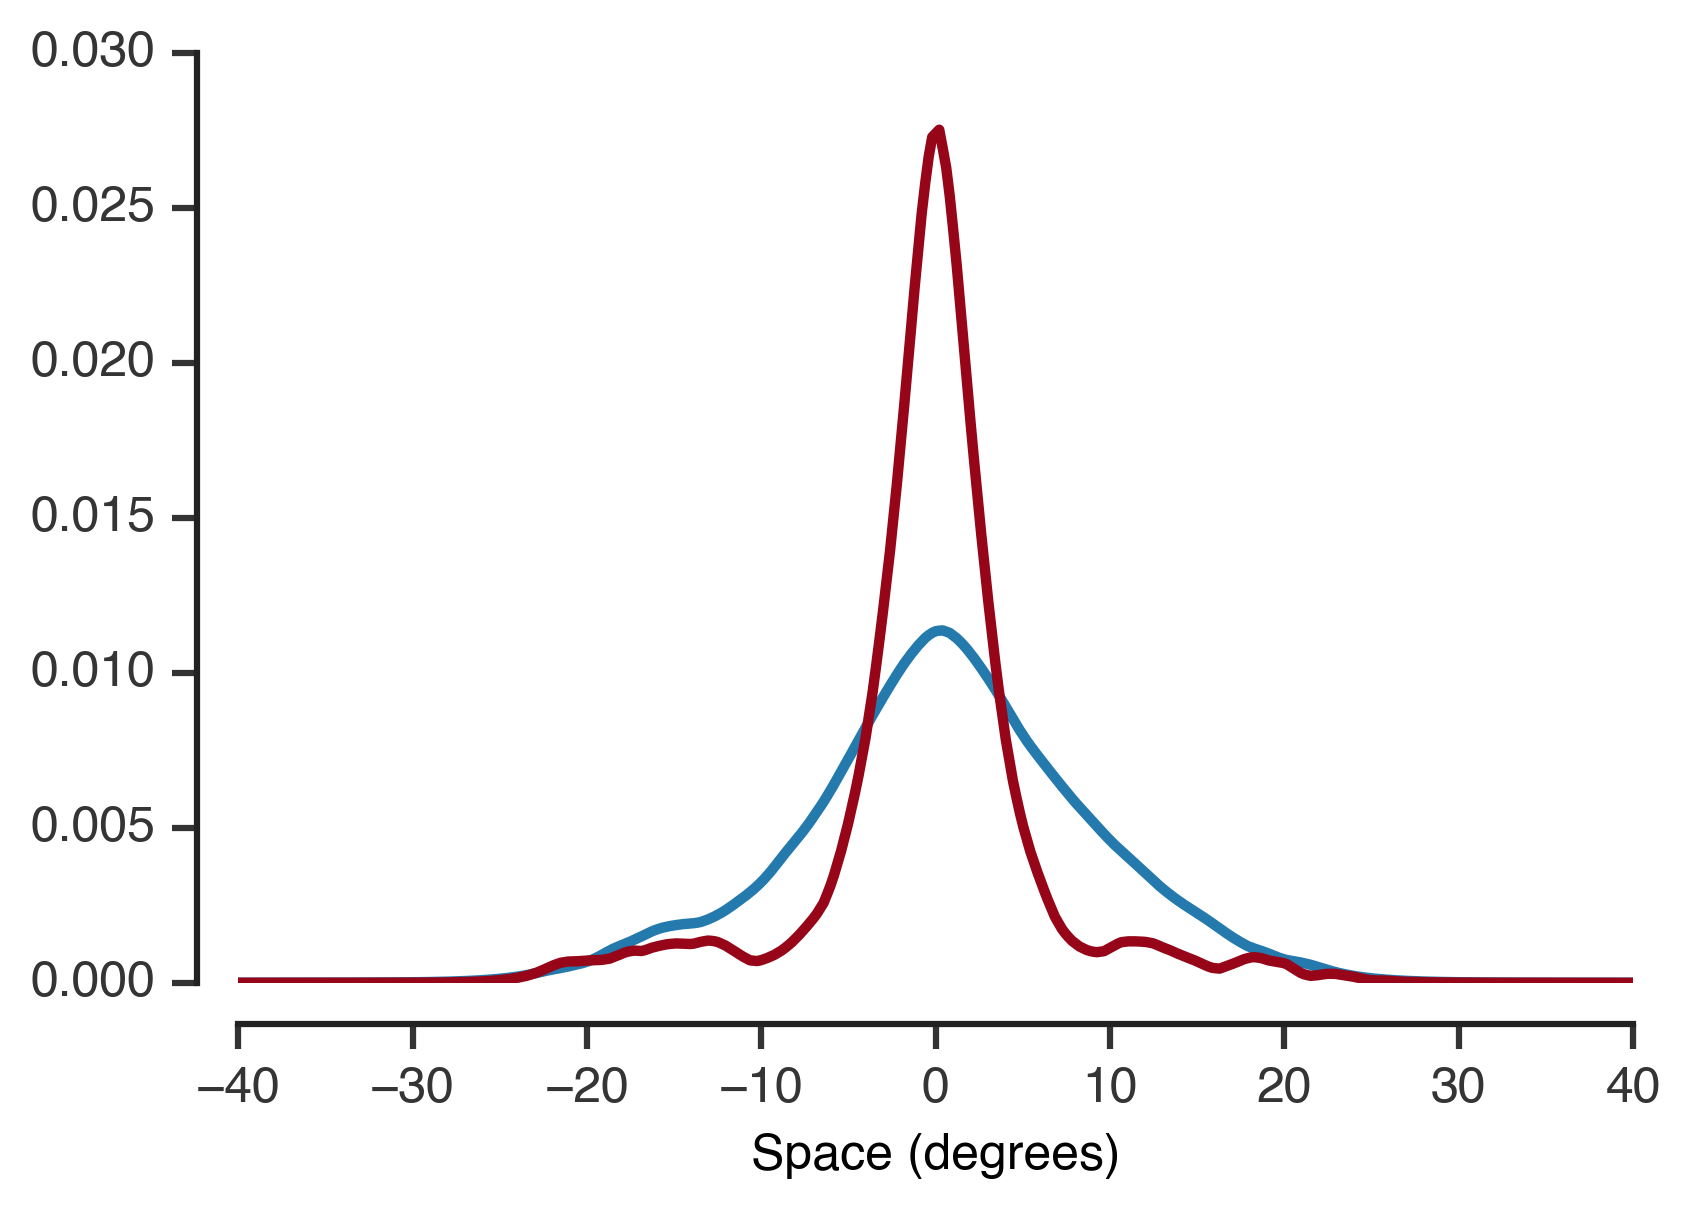

In [20]:
plt.plot(space, horz_pf)
plt.plot(space, ama_pf)
plt.xlabel('Space (degrees)')
adjust_spines(plt.gca())

Load David's 1721 ganglion cells

In [21]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [22]:
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

Get center widths for each celltype

In [23]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [24]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [25]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

126it [00:30,  5.57it/s]
28it [00:09,  1.18it/s]
772it [01:27, 12.01it/s]
253it [01:46,  5.63it/s]
249it [00:55,  6.23it/s]
321it [00:47,  9.66it/s]


In [26]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 5 in fast_on
couldn't fit 31 in slow_off
couldn't fit 3 in ganglion
couldn't fit 4 in fast_off_adapting
couldn't fit 9 in fast_off_sensitizing
couldn't fit 6 in medium_off_adapting


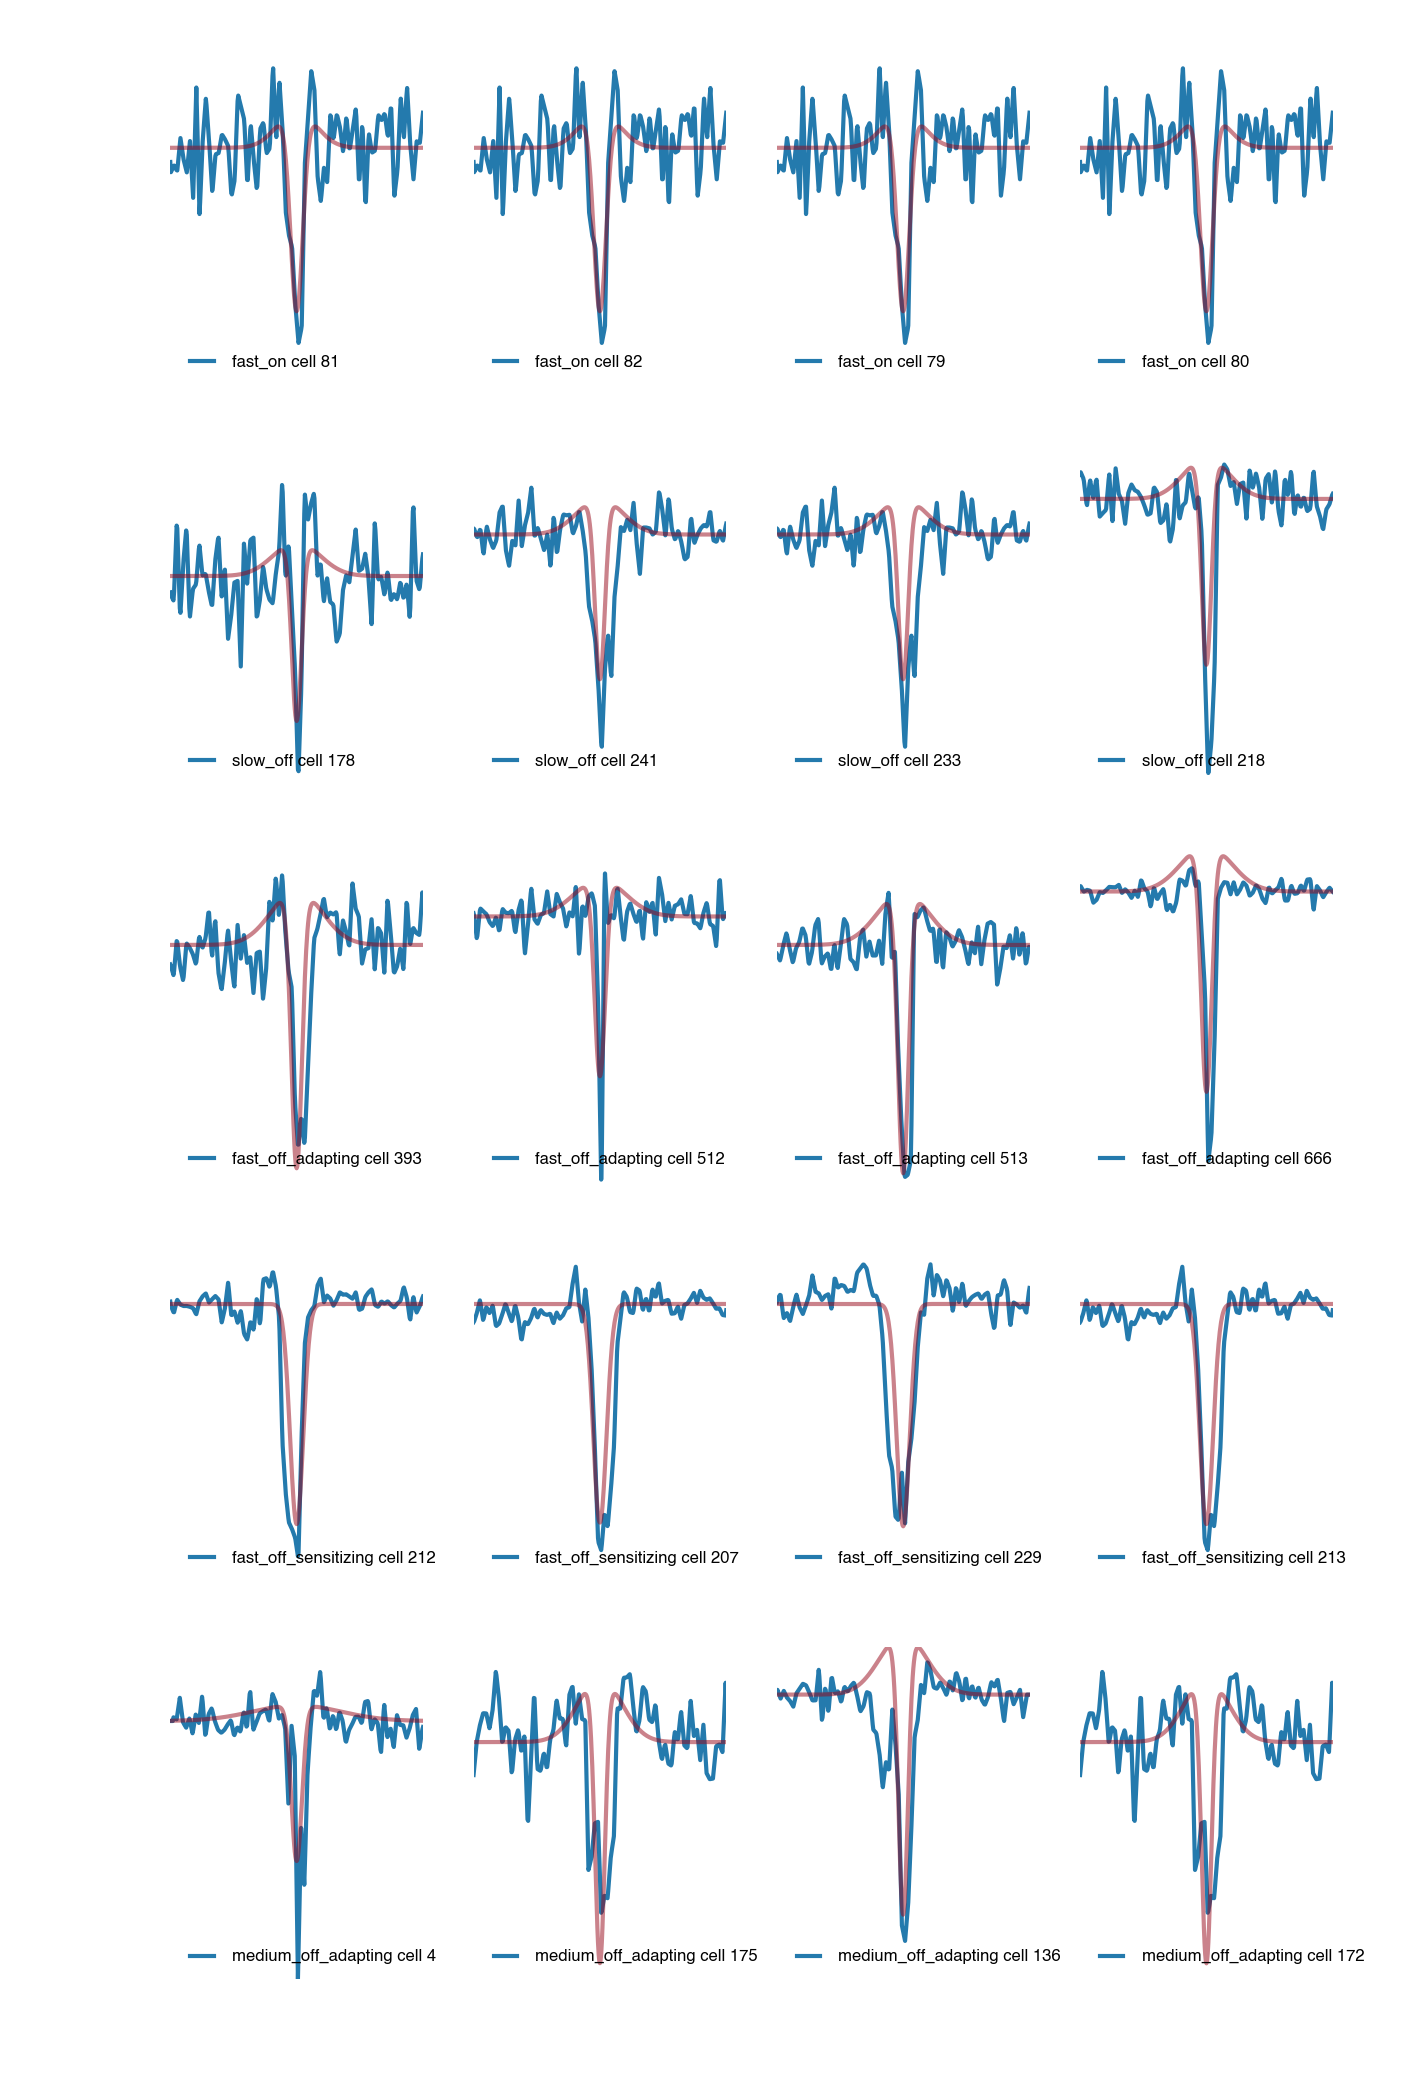

In [27]:
fig = plt.gcf()
fig.set_size_inches((5,10))
examples = 4
plot_id = 0
number_of_plots = examples * len([k for k in fit_failures.keys() if k not in ['ganglion']])
cols = 4
rows = number_of_plots//cols + 1
for celltype in fit_failures.keys():
    if celltype != 'ganglion':
        exs = np.random.choice(fit_failures[celltype], examples, replace=False)
        for idc in exs:
            plot_id += 1
            plt.subplot(rows, cols, plot_id)
            plt.plot(space, receptive_fields[celltype][idc], label='%s cell %d' %(celltype, idc),
                    linewidth=1)
            plt.plot(space, center_and_surround(space, center_widths[celltype][idc], surround_widths[celltype][idc],
                                               center_strengths[celltype][idc], surround_strengths[celltype][idc]),
                    linewidth=1, alpha=0.5)
            plt.legend(frameon=False, fontsize=4, loc='lower left')
            ax = plt.gca()
            ax.axis('off')
        

Plot the average profile across celltypes

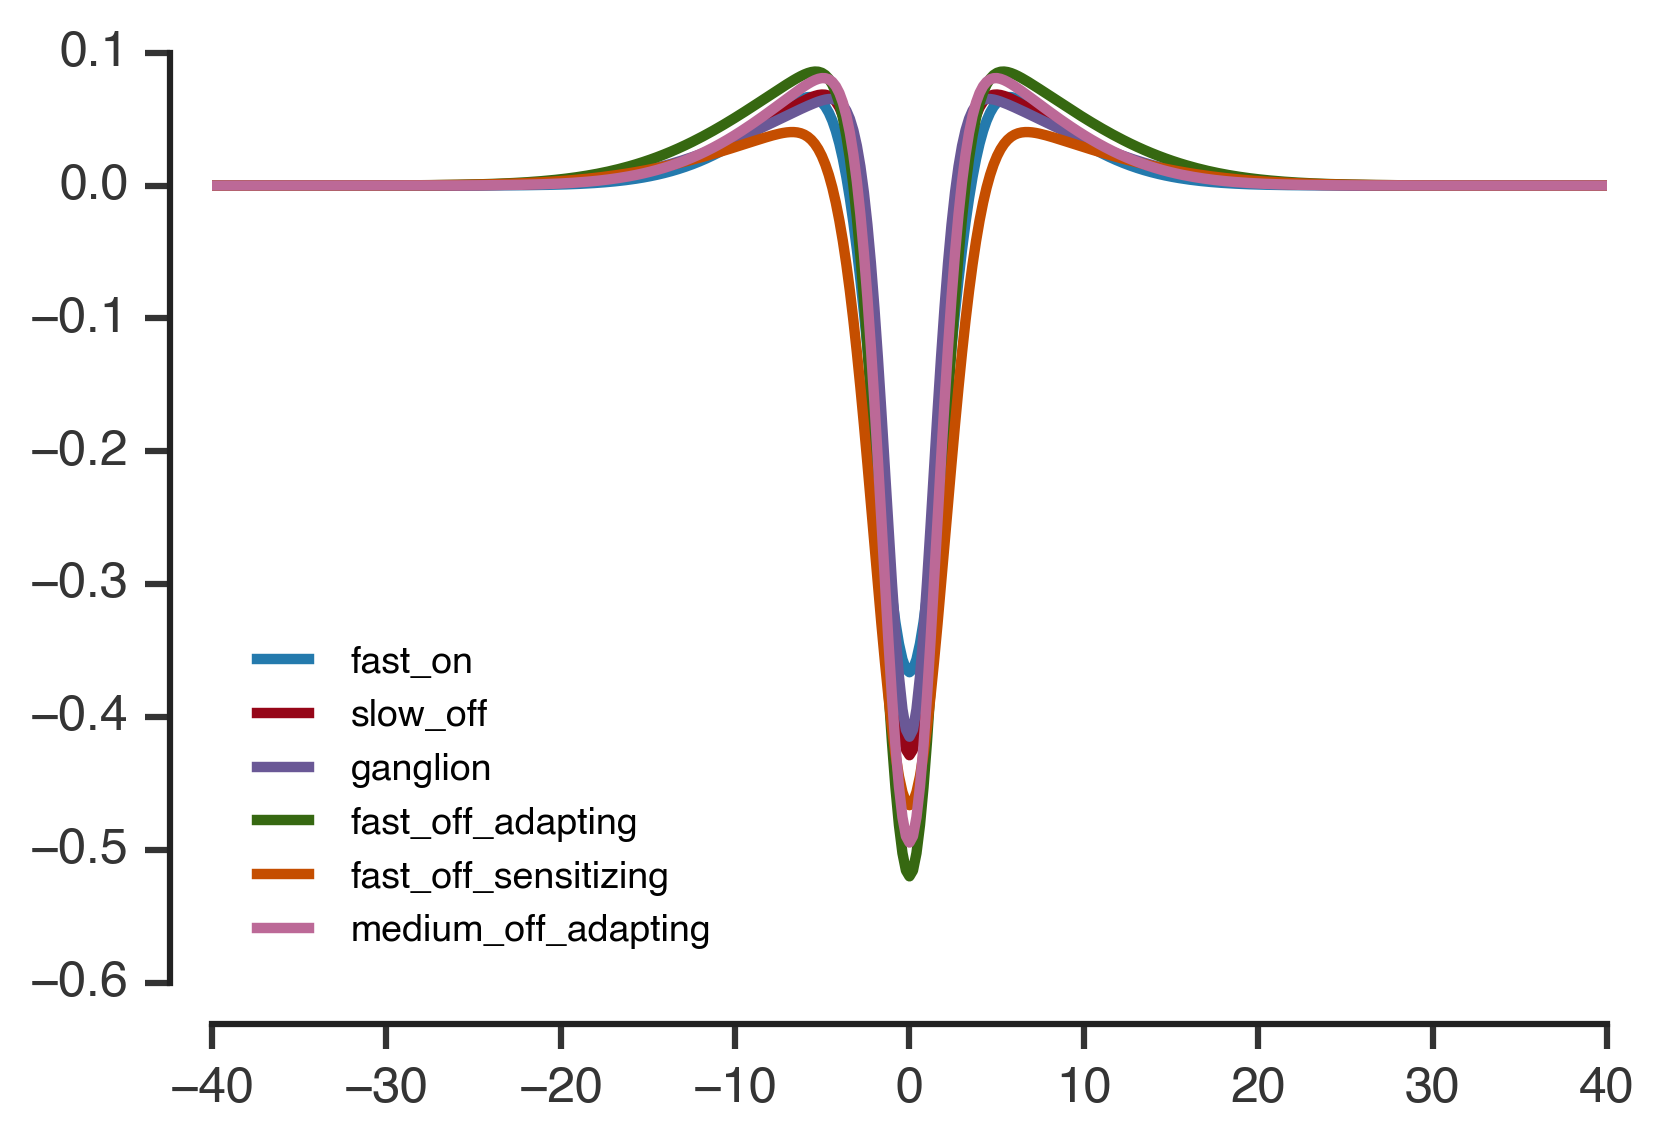

In [28]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
    plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
                                     median_center_strength, median_surround_strength), label=celltype)
plt.legend(frameon=False, fontsize=9, loc='lower left')
adjust_spines(plt.gca())

In [29]:
median_center_widths

{'fast_off_adapting': 1.6921005125265909,
 'fast_off_sensitizing': 2.0658102863813603,
 'fast_on': 1.9647399365227634,
 'ganglion': 1.3731413954345983,
 'medium_off_adapting': 1.5794333062701262,
 'slow_off': 1.5642116410053606}

Bar charts to visualize diversity

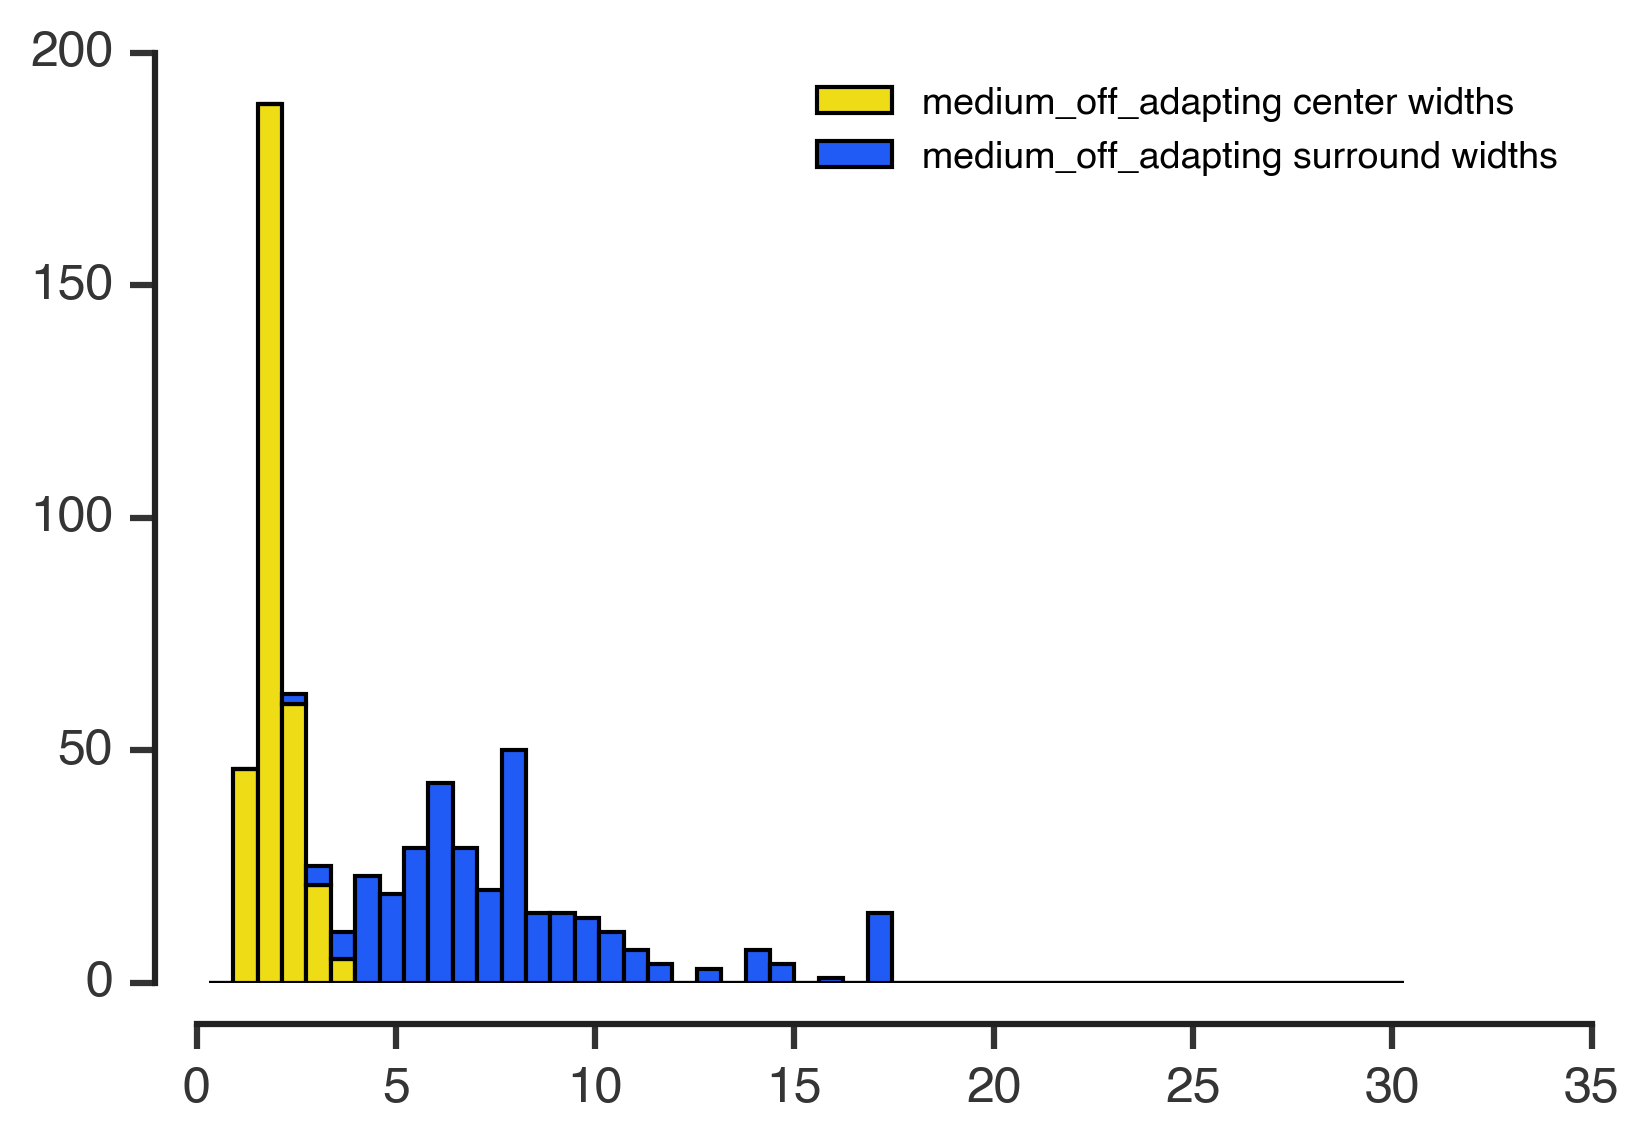

In [30]:
cws = np.array(center_widths[celltype])
sws = np.array(surround_widths[celltype])
# bins = np.linspace(np.min([cws]), np.max(sws[sws < 200]), 50)
bins = np.linspace(0,30,50)
counts, bins = np.histogram(cws[cws < 500], bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center widths' %celltype)

counts_surr, bins_surr = np.histogram(sws[sws < 500], bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s surround widths' %celltype, bottom=counts)

adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

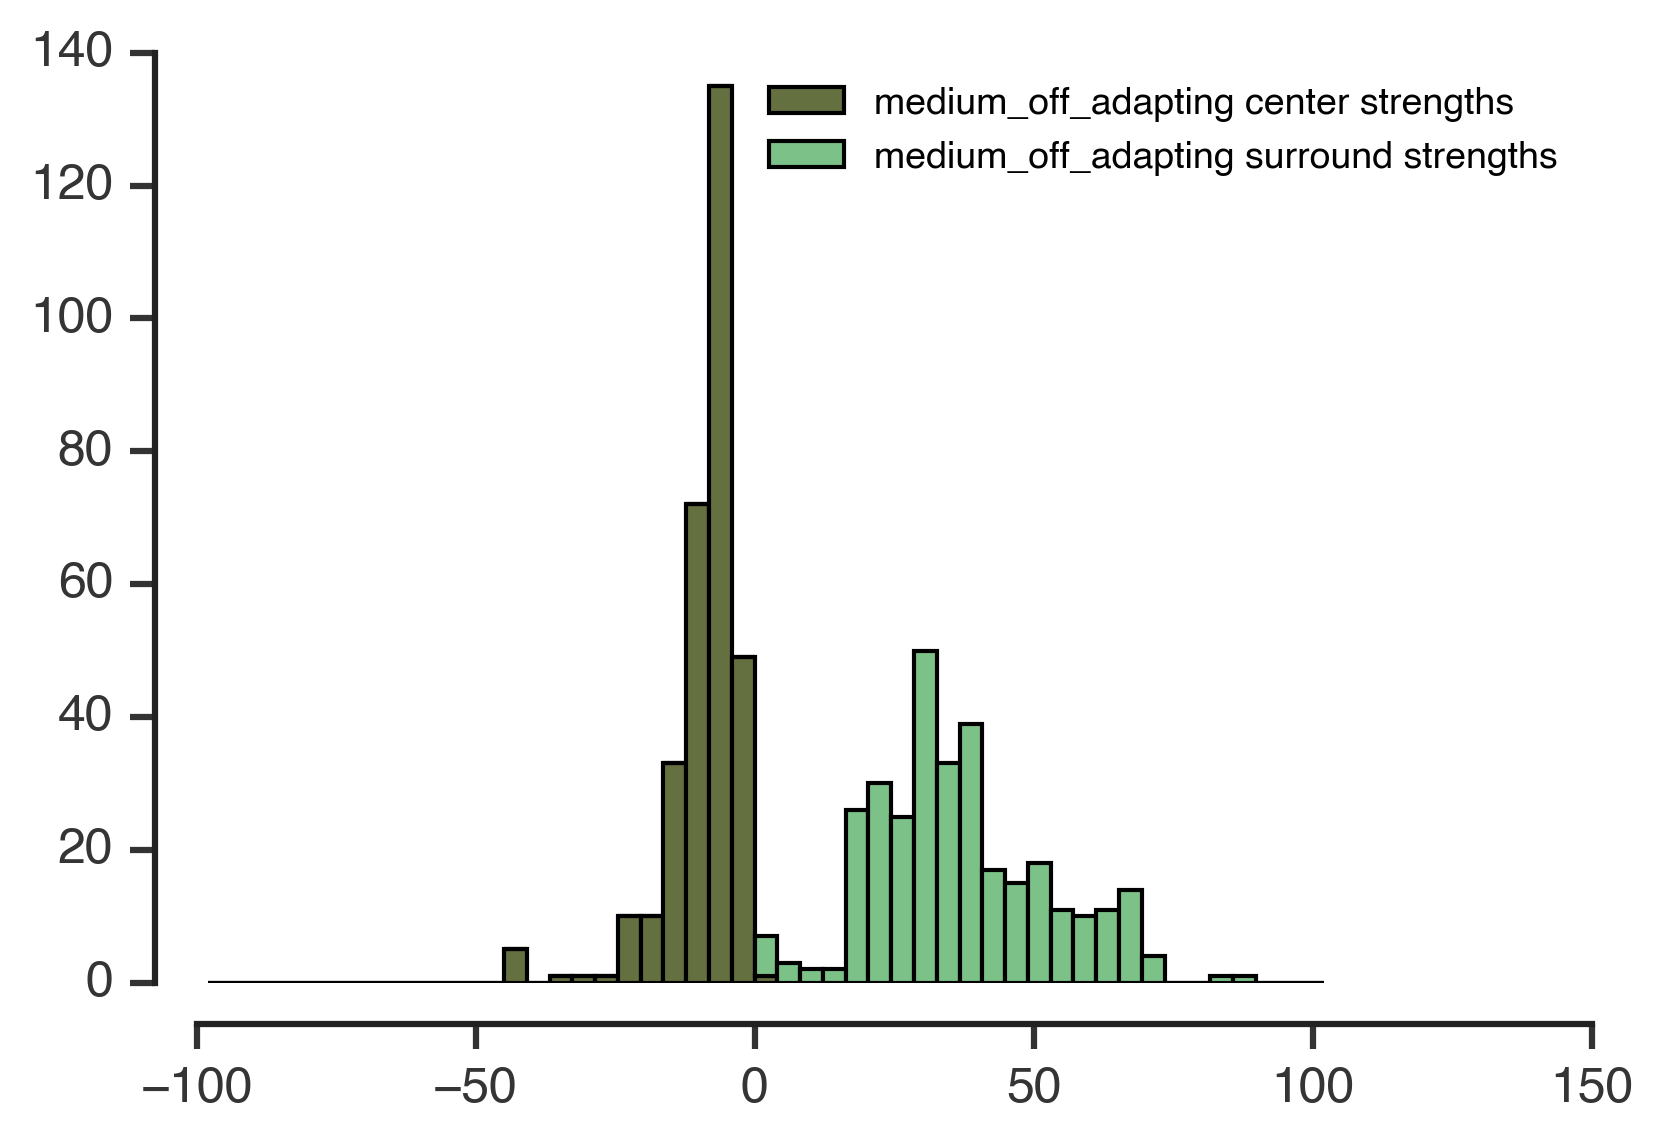

In [31]:
css = -abs(np.array(center_strengths[celltype]))
sss = abs(np.array(surround_strengths[celltype]))
# bins = np.linspace(np.min([css]), np.max(sss), 50)
bins = np.linspace(-100,100,50)
counts, bins = np.histogram(css, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center strengths' %celltype)

counts_surr, bins_surr = np.histogram(sss, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s surround strengths' %celltype, bottom=counts)

adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

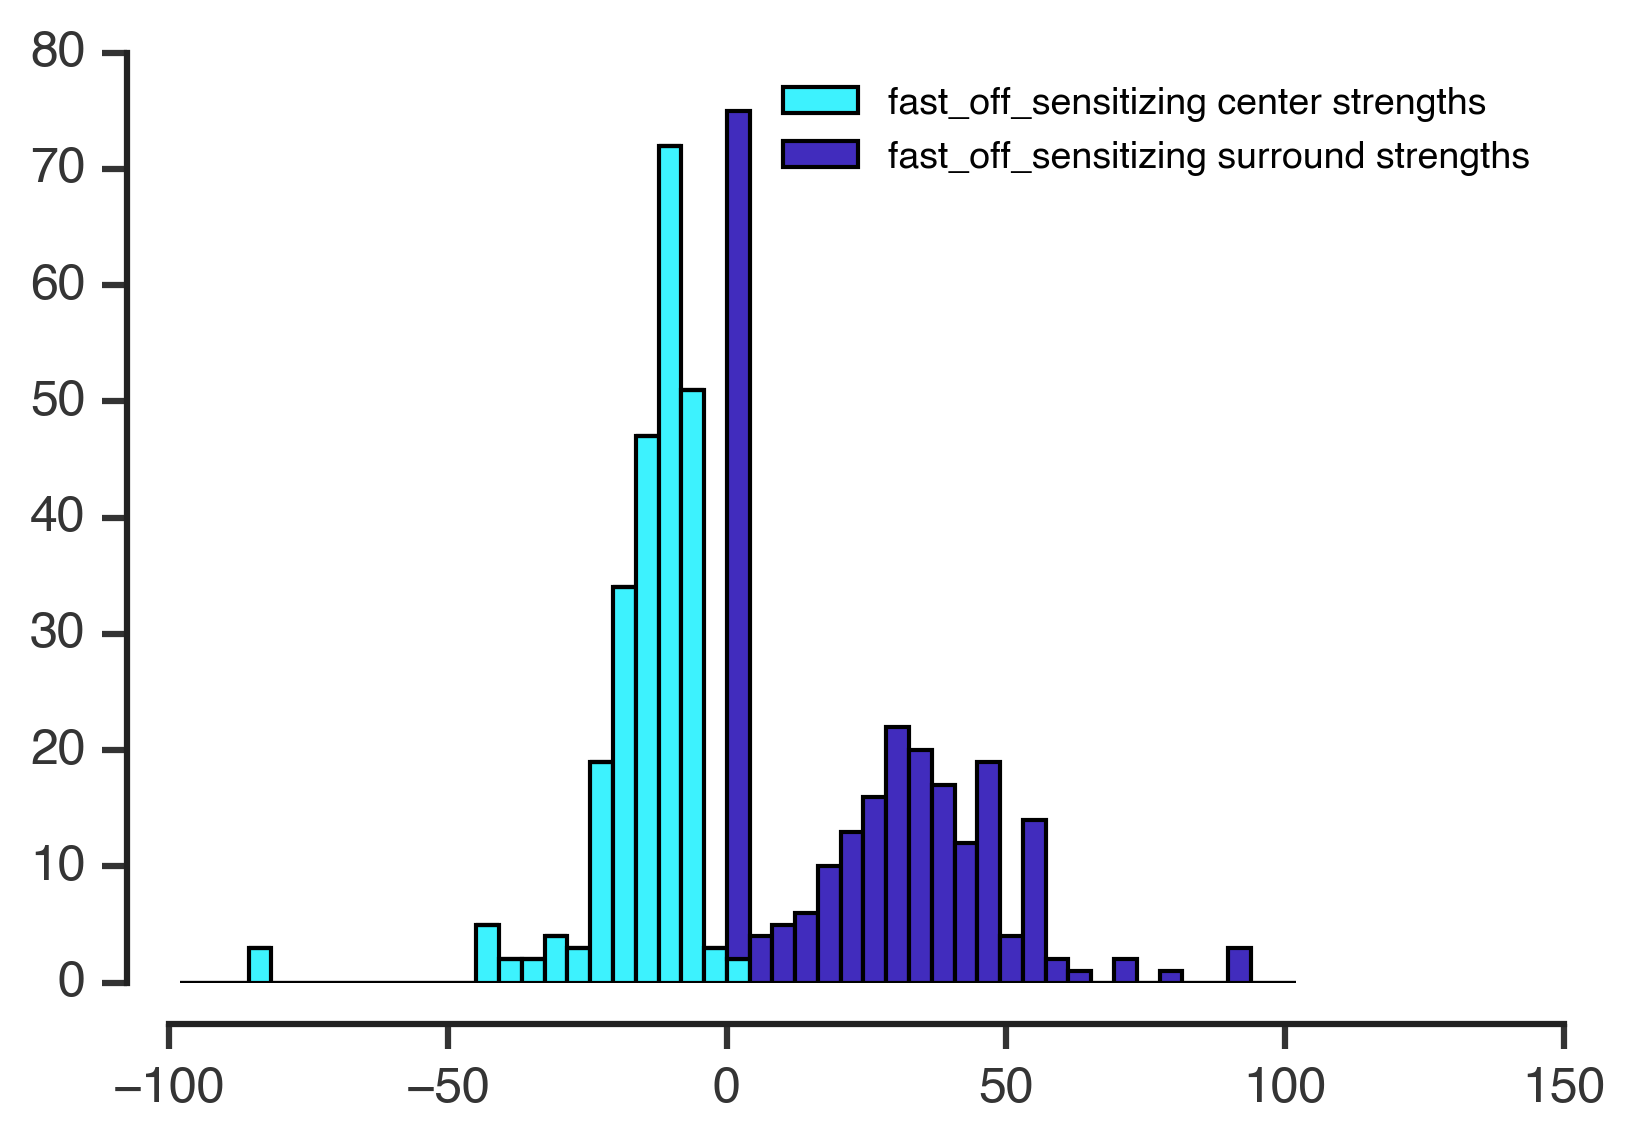

In [32]:
celltype = 'fast_off_sensitizing'
css = -abs(np.array(center_strengths[celltype]))
sss = abs(np.array(surround_strengths[celltype]))
# bins = np.linspace(np.min([css]), np.max(sss), 50)
bins = np.linspace(-100,100,50)
counts, bins = np.histogram(css, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center strengths' %celltype)

counts_surr, bins_surr = np.histogram(sss, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s surround strengths' %celltype, bottom=counts)

adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

# Model varying width of inhibitory pathways


In [33]:
widths = np.linspace(0.01, 20, 100)

In [ ]:
resolution = 100
init_filt_const = 10.9
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [ ]:
infos_varying_width = collections.defaultdict(list)
# for celltype in tqdm(median_center_widths.keys()):
celltype = 'fast_off_adapting'
info_maps_by_widths = collections.defaultdict(list)
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)
for idw1, width1 in enumerate(widths):
    surround1 = gaussian(x=space, sigma=width1, mu=0.)
    surround1 /= np.sum(surround1)
    for idw2, width2 in enumerate(widths[idw1:]):
        surround2 = gaussian(x=space, sigma=width2, mu=0.)
        surround2 /= np.sum(surround2)

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        infomap = np.zeros((resolution, resolution))
        for idh,hw in enumerate(horz_weights):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))

                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)

                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break

                filt_const = abs(filt_const_opt['x'])

                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps_by_widths[(width1, width2)] = infomap
infos_varying_width[celltype] = info_maps_by_widths

For each cell type, there is a map of information as a function of the two surround sizes. For each of these maps is another map of how information varies with weighting, conditioned on the two surround sizes.

In [ ]:
infos_varying_width.keys()

In [ ]:
celltype = 'fast_off_adapting'
for idw,w1 in enumerate(widths):
    for w2 in widths[idw:]:
        plt.scatter(w1, w2, color='k')
plt.xlabel('surround width 1 (degrees)')
plt.ylabel('surround width 2 (degrees)')

In [ ]:
max_info_vs_width = np.zeros((len(widths), len(widths)))
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        max_info_vs_width[idw1, idw2+idw1] = np.max(infos_varying_width[celltype][(w1,w2)])
        max_info_vs_width[idw2+idw1, idw1] = np.max(infos_varying_width[celltype][(w1,w2)])

In [ ]:
plt.imshow(max_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
plt.plot(widths, widths, 'k--', linewidth=1)
plt.xlabel('surround width 2')
plt.ylabel('surround width 1')
plt.colorbar()

### Plot data on this map

In [ ]:
popt_horz, pcov = curve_fit(gaussian, space, horz_pf, p0=[2.5, 0.0, 2.1])
popt_ama, pcov = curve_fit(gaussian, space, ama_pf, p0=[2.5, 0.0, 2.1])

In [ ]:
print(popt_horz)
print(popt_ama)

In [ ]:
plt.plot(space, horz_pf, 'g', label='horizontal rf component')
plt.plot(space, gaussian(space, *popt_horz), 'g--', label='gaussian fit to horz')
plt.plot(space, ama_pf, 'b', label='amacrine rf component')
plt.plot(space, gaussian(space, *popt_ama), 'b--', label='gaussian fit to ama')
plt.xlabel('space (degrees)')
plt.legend(frameon=False, loc='upper right', fontsize=9)
adjust_spines(plt.gca())

In [ ]:
plt.imshow(max_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
plt.colorbar()
plt.plot(widths, widths, 'k--', linewidth=1)
plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='w', linewidth=0.8)
plt.scatter(popt_ama[0], popt_horz[0], c='k', edgecolor='w', linewidth=0.8)
plt.xlabel('surround width 2')
plt.ylabel('surround width 1')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])

What does (2,10) or (2,5) look like?

In [ ]:
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)
width1 = widths[2]
width2 = widths[5]
surround1 = gaussian(x=space, sigma=width1, mu=0.)
surround1 /= np.sum(surround1)
surround2 = gaussian(x=space, sigma=width2, mu=0.)
surround2 /= np.sum(surround2)

def rf_model(horz_weight, center_weight):
    return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

plt.plot(space, rf_model(0.8, 0.6), color='k', alpha=0.7, linewidth=1)
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

In [ ]:
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)
width1 = widths[2]
width2 = widths[10]
surround1 = gaussian(x=space, sigma=width1, mu=0.)
surround1 /= np.sum(surround1)
surround2 = gaussian(x=space, sigma=width2, mu=0.)
surround2 /= np.sum(surround2)

def rf_model(horz_weight, center_weight):
    return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

plt.plot(space, rf_model(0.8, 0.6), color='k', alpha=0.7, linewidth=1)
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

### Check that the info maps per parameter look reasonable

Closest to past surround data is:

In [ ]:
print(widths[4])
print(widths[9])

In [ ]:
plt.imshow(infos_varying_width[celltype][(widths[4], widths[9])], origin='bottom left',
          extent=(center_weights[0], center_weights[-1], horz_weights[0], horz_weights[-1]),
          aspect='auto')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.xlim([center_weights[0], center_weights[-1]])
# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

What's happening at the slight diagonal to the left of 0.5 center weight?

In [ ]:
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)
width1 = widths[4]
width2 = widths[9]
surround1 = gaussian(x=space, sigma=width1, mu=0.)
surround1 /= np.sum(surround1)
surround2 = gaussian(x=space, sigma=width2, mu=0.)
surround2 /= np.sum(surround2)

def rf_model(horz_weight, center_weight):
    return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

these_cws = [cw for cw in center_weights if (cw >= 0.4) and (cw <= 0.5)]
model_means = []
for cw in these_cws:
    plt.plot(space, rf_model(1.0, cw), color='k', alpha=0.7, linewidth=1)
    model_means.append(np.mean(rf_model(1.0, cw)))
    
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

In [ ]:
plt.plot(these_cws, model_means)

In [ ]:
plt.plot(center_weights, infos_varying_width[celltype][(widths[4], widths[9])][-1,:])
plt.xlabel('Center weight')

### So it does look very similar to what we've seen before. What does it look like for a very different combo of surround sizes?

In [ ]:
min_info = None
max_info = None
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        new_min = np.min(infos_varying_width[celltype][(w1,w2)])
        new_max = np.max(infos_varying_width[celltype][(w1,w2)])
        if (not min_info) or (min_info > new_min):
            min_info = new_min
        if (not max_info) or (max_info < new_max):
            max_info = new_max

In [ ]:
min_info

In [ ]:
max_info

In [ ]:
id1 = -1
id2 = -1
plt.imshow(infos_varying_width[celltype][(widths[id1], widths[id2])], origin='bottom left',
          extent=(center_weights[0], center_weights[-1], horz_weights[0], horz_weights[-1]),
          aspect='auto')
plt.title('1st surround width = %0.1f, 2nd = %0.1f' %(widths[id1], widths[id2]), fontsize=16)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.ylim([0,1])
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.xlim([center_weights[0], center_weights[-1]])
# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

In [ ]:
massive_info_table = np.zeros((len(horz_weights)*len(widths), len(center_weights)*len(widths)))
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        massive_info_table[(len(horz_weights)*idw1):(len(horz_weights)*(idw1+1)),
                           len(center_weights)*(idw1+idw2):(len(center_weights)*(idw1+idw2+1))] = infos_varying_width[celltype][(w1,w2)]

In [ ]:
plt.imshow(massive_info_table, origin='bottom left')
plt.ylim(200,500)
plt.xlim(700,900)

In [ ]:
plt.imshow(massive_info_table, origin='bottom left', clim=[min_info, max_info],
          extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.xlabel('surround width 2')
plt.ylabel('surround width 1')
plt.savefig('massive info table.png')

## Explore other metrics of the space

#### Mean

In [ ]:
mean_info_vs_width = np.zeros((len(widths), len(widths)))
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        mean_info_vs_width[idw1, idw2+idw1] = np.mean(infos_varying_width[celltype][(w1,w2)])
        mean_info_vs_width[idw2+idw1, idw1] = np.mean(infos_varying_width[celltype][(w1,w2)])

In [ ]:
plt.imshow(mean_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.plot(widths, widths, 'k--', linewidth=1)
plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='w', linewidth=0.8)
plt.scatter(popt_ama[0], popt_horz[0], c='k', edgecolor='w', linewidth=0.8)
plt.xlabel('surround width 2')
plt.ylabel('surround width 1')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])

#### Min

In [ ]:
min_info_vs_width = np.zeros((len(widths), len(widths)))
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        min_info_vs_width[idw1, idw2+idw1] = np.min(infos_varying_width[celltype][(w1,w2)])
        min_info_vs_width[idw2+idw1, idw1] = np.min(infos_varying_width[celltype][(w1,w2)])

In [ ]:
plt.imshow(min_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.plot(widths, widths, 'k--', linewidth=1)
plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='w', linewidth=0.8)
plt.scatter(popt_ama[0], popt_horz[0], c='k', edgecolor='w', linewidth=0.8)
plt.xlabel('surround width 2')
plt.ylabel('surround width 1')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])

#### Median

In [ ]:
median_info_vs_width = np.zeros((len(widths), len(widths)))
for idw1,w1 in enumerate(widths):
    for idw2,w2 in enumerate(widths[idw1:]):
        median_info_vs_width[idw1, idw2+idw1] = np.median(infos_varying_width[celltype][(w1,w2)])
        median_info_vs_width[idw2+idw1, idw1] = np.median(infos_varying_width[celltype][(w1,w2)])

In [ ]:
plt.imshow(median_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.plot(widths, widths, 'k--', linewidth=1)
plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='w', linewidth=0.8)
plt.scatter(popt_ama[0], popt_horz[0], c='k', edgecolor='w', linewidth=0.8)
plt.xlabel('surround width 2')
plt.ylabel('surround width 1')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])

## What do these RF models look like?

In [ ]:
models = {}
center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)
for idw1, width1 in enumerate(widths):
    surround1 = gaussian(x=space, sigma=width1, mu=0.)
    surround1 /= np.sum(surround1)
    for idw2, width2 in enumerate(widths[idw1:]):
        surround2 = gaussian(x=space, sigma=width2, mu=0.)
        surround2 /= np.sum(surround2)

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        plt.plot(space, rf_model(0.8, 0.6), color=[idw1/30, 1, idw2/30], alpha=0.7, linewidth=1)
        models[(width1, width2)] = rf_model(0.8, 0.6)
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

In [ ]:
median_center_widths['fast_on']

In [ ]:
plt.plot(space, models[(widths[0], widths[0])])
plt.plot(space, gaussian(space, 1.964))
# plt.xlim(-5,5)

In [ ]:
plt.plot(space, models[(widths[4], widths[9])], linewidth=2, alpha=0.7)
plt.plot(space, models[(widths[9], widths[9])], linewidth=2, alpha=0.7)

In [ ]:
plt.plot(space, models[(widths[20], widths[29])], linewidth=2, alpha=0.7, label='w$_1$ = %0.f, w$_2$ = %0.f' %(widths[20], widths[29]))
plt.plot(space, models[(widths[20], widths[20])], linewidth=2, alpha=0.7, label='w$_1$ = %0.f, w$_2$ = %0.f' %(widths[20], widths[20]))
plt.plot(space, models[(widths[4], widths[20])], linewidth=2, alpha=0.7, label='w$_1$ = %0.f, w$_2$ = %0.f' %(widths[4], widths[20]))
plt.plot(space, models[(widths[9], widths[9])], linewidth=2, alpha=0.7, label='w$_1$ = %0.f, w$_2$ = %0.f' %(widths[9], widths[9]))
plt.plot(space, models[(widths[2], widths[3])], linewidth=2, alpha=0.7, label='w$_1$ = %0.f, w$_2$ = %0.f' %(widths[2], widths[3]))
plt.legend(loc='lower left', frameon=False, fontsize=9)
adjust_spines(plt.gca())
plt.xlabel('Space (degrees)')

# Plot all horizontal, amacrine cell data on the info maps

In [ ]:
data_dir = os.path.expanduser('~/data/kastner/')
h_file = 'horizontals.h5'
a_file = 'amacrines.h5'

In [ ]:
interneuron_rfs = collections.defaultdict(list)
with h5py.File(data_dir + h_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        interneuron_rfs['horizontal'].append(sign_of_pc * g_pca)

with h5py.File(data_dir + a_file, 'r') as f:
    keys = [str(k)[3:-2] for k in list(f['expts'])]
    for ide,expt in tqdm(enumerate(keys)):
        rf = np.array(f['lines/rfs/%s' %expt])
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        interneuron_rfs['amacrine'].append(sign_of_pc * g_pca)

In [ ]:
space_constant = {
    'horizontal': 118./microns_per_degree,
    'amacrine': 78./microns_per_degree
    }
conv_mode = 'full'
# spatial delta in mm * 1000) / microns_per_degree # microns * degrees/microns = degrees
interneuron_spacing = (2.2/100.) # in mm

interneuron_rfs_1d = collections.defaultdict(list)
for interneuron_type in interneuron_rfs.keys():
    for rf in interneuron_rfs[interneuron_type]:
        this_space = get_space(rf, interneuron_spacing, microns_per_degree, in_degrees=True, kind='peak')
        proj_range = [np.exp(-abs(t)/space_constant[interneuron_type]) for t in np.linspace(np.min(this_space),
                                                                                    np.max(this_space),len(this_space))]
        proj_field = np.convolve(proj_range, rf, mode=conv_mode)
        proj_field *= np.mean(rf) / np.mean(proj_field)
        
        proj_space = get_space(proj_field, np.diff(this_space[:2]), microns_per_degree, in_degrees=False)
        component_interp = interp1d(proj_space, proj_field, kind='slinear', bounds_error=False, fill_value=[0])
        interneuron_rfs_1d[interneuron_type].append(component_interp(space))

In [ ]:
colorscheme = {
    'horizontal': 'g',
    'amacrine': 'b'
}

In [ ]:
interneuron_fits = collections.defaultdict(list)
for interneuron_type in interneuron_rfs_1d.keys():
    for component in interneuron_rfs_1d[interneuron_type]:
        plt.plot(space, component/np.max(abs(component)), color=colorscheme[interneuron_type], alpha=0.5)

plt.plot(space, -horz_pf/np.max(abs(horz_pf)), 'k', linewidth=8)
plt.plot(space, -horz_pf/np.max(abs(horz_pf)), 'g')
plt.plot(space, -ama_pf/np.max(abs(ama_pf)), 'k', linewidth=8)
plt.plot(space, -ama_pf/np.max(abs(ama_pf)), 'b')

In [ ]:
popt_horz

In [ ]:
interneuron_fits = collections.defaultdict(list)
for interneuron_type in interneuron_rfs_1d.keys():
    for component in interneuron_rfs_1d[interneuron_type]:
        popt, pcov = curve_fit(gaussian, space, -component, p0=[2.5, 0.0, 2.1])
        interneuron_fits[interneuron_type].append(abs(popt[0]))

In [ ]:
plt.imshow(max_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.plot(widths, widths, 'k--', linewidth=1)
# plt.scatter(popt_ama[0], popt_horz[0], c='k', edgecolor='g', linewidth=0.8)
# for interneuron_type in interneuron_fits.keys():
for horz_fit in interneuron_fits['horizontal']:
    for ama_fit in interneuron_fits['amacrine']:
        plt.scatter(horz_fit, ama_fit, c='k', edgecolor='w', linewidth=0.8, s=10, alpha=0.4)
plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='g', linewidth=0.8, s=10)
plt.xlabel('horizontal cell width (degrees)')
plt.ylabel('amacrine cell width (degrees)')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])

In [ ]:
plt.imshow(max_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.plot(widths, widths, 'k--', linewidth=1)
# plt.scatter(popt_ama[0], popt_horz[0], c='k', edgecolor='g', linewidth=0.8)
# for interneuron_type in interneuron_fits.keys():
for horz_fit in interneuron_fits['horizontal']:
    plt.vlines(horz_fit, widths[0], widths[-1], color='g', linewidth=1, linestyle='--', alpha=0.5)
for ama_fit in interneuron_fits['amacrine']:
    plt.plot(widths, ama_fit * np.ones_like(widths), 'b--', linewidth=1, alpha=0.5)
plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='g', linewidth=0.8, s=10)
plt.xlabel('horizontal cell width (degrees)')
plt.ylabel('amacrine cell width (degrees)')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])

### Try contour plot

In [ ]:
count_horz, horz_edges = np.histogram(interneuron_fits['horizontal'], bins=widths)
count_ama, ama_edges = np.histogram(interneuron_fits['amacrine'], bins=widths)

In [ ]:
bar_width = np.mean(np.diff(horz_edges))
plt.bar(horz_edges[:-1] + bar_width/2, count_horz, width=bar_width, color=np.random.rand(3), alpha=0.6)
plt.bar(ama_edges[:-1] + bar_width/2, count_ama, width=bar_width, color=np.random.rand(3), alpha=0.6)

In [ ]:
widths_high_res = np.linspace(widths[0], widths[-1], 50)
count_horz, horz_edges = np.histogram(interneuron_fits['horizontal'], bins=widths_high_res)
count_ama, ama_edges = np.histogram(interneuron_fits['amacrine'], bins=widths_high_res)

bar_width = np.mean(np.diff(horz_edges))
plt.bar(horz_edges[:-1] + bar_width/2, count_horz, width=bar_width, color=np.random.rand(3), alpha=0.6)
plt.bar(ama_edges[:-1] + bar_width/2, count_ama, width=bar_width, color=np.random.rand(3), alpha=0.6)

2d histogram

In [ ]:
interneuron_pairs = np.outer(count_horz, count_ama)

In [ ]:
fig = plt.gcf()
fig.set_size_inches((2,2))
plt.imshow(interneuron_pairs)

In [ ]:
plt.imshow(max_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.plot(widths, widths, 'k--', linewidth=1)
X, Y = np.meshgrid(horz_edges[:-1] + bar_width/2, ama_edges[:-1] + bar_width/2)
plt.contour(X, Y, interneuron_pairs.T, 3, linewidths=0.7, alpha=1, colors=['g', 'c', 'b'])
# plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='g', linewidth=0.8, s=10)
plt.xlabel('horizontal cell width (degrees)')
plt.ylabel('amacrine cell width (degrees)')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])

In [ ]:
widths_high_res = widths #np.linspace(widths[0], widths[-1], 50)
count_horz, horz_edges = np.histogram(interneuron_fits['horizontal'], bins=widths_high_res)
count_ama, ama_edges = np.histogram(interneuron_fits['amacrine'], bins=widths_high_res)

interneuron_pairs = np.outer(count_horz, count_ama)

plt.imshow(max_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.plot(widths, widths, 'k--', linewidth=1)
X, Y = np.meshgrid(horz_edges[:-1] + bar_width/2, ama_edges[:-1] + bar_width/2)
plt.contour(X, Y, interneuron_pairs.T, 3, linewidths=0.7, alpha=1, colors=['g', 'c', 'b'])
# plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='g', linewidth=0.8, s=10)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('horizontal cell width (degrees)')
plt.ylabel('amacrine cell width (degrees)')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])

In [ ]:
widths_high_res = widths #np.linspace(widths[0], widths[-1], 50)
count_horz, horz_edges = np.histogram(interneuron_fits['horizontal'], bins=widths_high_res)
count_ama, ama_edges = np.histogram(interneuron_fits['amacrine'], bins=widths_high_res)

interneuron_pairs = np.outer(count_horz, count_ama)

plt.imshow(max_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.plot(widths, widths, 'k--', linewidth=1)

# contour
contour_colors = ['g', 'c', 'b']
X, Y = np.meshgrid(horz_edges[:-1] + bar_width/2, ama_edges[:-1] + bar_width/2)
CS = plt.contour(X, Y, interneuron_pairs.T, 3, linewidths=0.7, alpha=1, colors=contour_colors)
# manual_locations= [(20,10), (20, 8), (10.1, 6)]
# plt.clabel(CS, inline=1, fontsize=8, manual=manual_locations)
contour_counts = CS.levels
for i,c in enumerate(contour_counts):
    plt.text(16, 12-1.8*i, '%d interneuron cell pairs' %c, fontsize=9, color=contour_colors[i])
    

# plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='g', linewidth=0.8, s=10)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('horizontal cell width (degrees)')
plt.ylabel('amacrine cell width (degrees)')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])
plt.savefig('varying inhibitory spatial scale with data.pdf')

In [ ]:
np.unique(interneuron_pairs)

In [ ]:
np.sum(interneuron_pairs)

In [ ]:
len(interneuron_fits['horizontal'])

In [ ]:
len(interneuron_fits['amacrine'])

In [ ]:
plt.imshow(min_info_vs_width, origin='bottom left', extent=[widths[0], widths[-1], widths[0], widths[-1]])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)
plt.plot(widths, widths, 'k--', linewidth=1)

# contour
contour_colors = ['g', 'c', 'b']
X, Y = np.meshgrid(horz_edges[:-1] + bar_width/2, ama_edges[:-1] + bar_width/2)
CS = plt.contour(X, Y, interneuron_pairs.T, 3, linewidths=0.7, alpha=1, colors=contour_colors)
# manual_locations= [(20,10), (20, 8), (10.1, 6)]
# plt.clabel(CS, inline=1, fontsize=8, manual=manual_locations)
contour_counts = CS.levels
for i,c in enumerate(contour_counts):
    plt.text(16, 12-1.8*i, '%d interneuron cell pairs' %c, fontsize=9, color=contour_colors[i])
    

# plt.scatter(popt_horz[0], popt_ama[0], c='k', edgecolor='g', linewidth=0.8, s=10)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('horizontal cell width (degrees)')
plt.ylabel('amacrine cell width (degrees)')
plt.xlim(widths[0], widths[-1])
plt.ylim(widths[0], widths[-1])
plt.savefig('varying inhibitory spatial scale with data.pdf')

### what do the shapes of ffts look like at each point in this space?

In [ ]:
max_info_ffts = np.zeros((len(widths), len(widths), len(average_ganglion_fft)))
max_info_params = collections.defaultdict(list)

center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
center /= -np.sum(center)

for idw1,w1 in enumerate(widths):
    surround1 = gaussian(x=space, sigma=w1, mu=0.)
    surround1 /= np.sum(surround1)
    for idw2,w2 in enumerate(widths[idw1:]):
        surround2 = gaussian(x=space, sigma=w2, mu=0.)
        surround2 /= np.sum(surround2)

        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*surround2 + (1-horz_weight)*surround1)

        this_map = infos_varying_width[celltype][(w1,w2)]
        which_fft = np.unravel_index(this_map.argmax(), this_map.shape)
        hw = horz_weights[which_fft[0]]
        cw = center_weights[which_fft[1]]
        max_info_params['hw'].append(hw)
        max_info_params['cw'].append(cw)
        
        rf_filt = abs(np.fft.rfft(rf_model(hw, cw)))
        
        # constrain model
        def constrain_filt_power(filt_const):
            size = len(rf_filt)
            output_power = np.sum((signal*filt_const*rf_filt)**2 
                                  + (input_noise*filt_const*rf_filt)**2
                                  + output_noise**2)

            return (target_power - output_power)**2

        filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
        iterations = 0
        new_init_filt_const = init_filt_const
        while not filt_const_opt.success:
            iterations += 1
            new_init_filt_const *= 10
            filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
            if iterations > 10:
                print(filt_const_opt)
                break

        filt_const = abs(filt_const_opt['x'])
        
        
        max_info_ffts[idw1, idw2+idw1] = filt_const * rf_filt
        max_info_ffts[idw2+idw1, idw1] = max_info_ffts[idw1, idw2+idw1]

In [ ]:
cws = np.array(max_info_params['cw'])
hws = np.array(max_info_params['hw'])
bins = np.linspace(-0.0, 1.0, 50)
# bins = np.linspace(0,30,50)
counts, bins = np.histogram(cws, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s center weights' %celltype)

counts_surr, bins_surr = np.histogram(hws, bins=bins)
plt.bar(bins[:-1]+np.mean(np.diff(bins))/2, counts_surr, width=np.mean(np.diff(bins)), color=np.random.rand(3),
       label='%s horizontal weights' %celltype, bottom=counts)

plt.xlim(0,1.05)
plt.xlabel('Weights')
adjust_spines(plt.gca())
plt.legend(frameon=False, fontsize=9)

In [ ]:
plt.plot(freqs, max_info_ffts[-1, -1])
plt.plot(freqs, max_info_ffts[0, 0])
adjust_spines(plt.gca())

In [ ]:
np.sum((signal*max_info_ffts[0, 0])**2 + (input_noise*max_info_ffts[0, 0])**2 + output_noise**2)

In [ ]:
np.sum((signal*max_info_ffts[-1, -1])**2 + (input_noise*max_info_ffts[-1, -1])**2 + output_noise**2)

In [ ]:
is1 = 0
is2 = 0
signal_power = (max_info_ffts[is1, is2] * signal)**2
noise_power = (max_info_ffts[is1, is2] * input_noise)**2 + output_noise**2
this_info = 0.5*np.log2(1 + signal_power/noise_power)
plt.plot(freqs, np.cumsum(this_info))

is1 = -1
is2 = -1
signal_power = (max_info_ffts[is1, is2] * signal)**2
noise_power = (max_info_ffts[is1, is2] * input_noise)**2 + output_noise**2
this_info = 0.5*np.log2(1 + signal_power/noise_power)
plt.plot(freqs, np.cumsum(this_info))

In [ ]:
np.min(max_info_vs_width)